In [ ]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

# ==========================================
# CONFIGURATION GENERATOR
# ==========================================
# Use this cell to generate specific sensor configurations before running the solver.

# 1. Parameters
N = 32
num_observation = 100  # <--- Change this to generate different sensor counts (e.g., 10, 50)
num_truncated_series = 32 # Latent dimension for NS (Standard is 24)
seed = 42 # Change seed for different random sensor placements

print(f"Generating configuration for {num_observation} observations...")

# 2. Generate Random Observation Locations
key = jax.random.PRNGKey(seed)
# Total grid points = N*N. We select 'num_observation' unique indices.
# Note: We exclude the last point N*N-1 if strictly following original script logic,
# but generally choice over N*N is fine. Original script used arange(N*N-1).
possible_indices = jnp.arange(N * N)
obs_indices = jax.random.choice(key, possible_indices, shape=(num_observation,), replace=False)
obs_indices = np.array(obs_indices) # Convert to numpy for saving

# 3. Load and Truncate Basis
# We need the source file 'data/Basis_Modes.csv' which contains the top 100 modes.
try:
    df_modes = pd.read_csv('data/Basis_Modes.csv', header=None)

    # Handle potential header in source file
    if isinstance(df_modes.iloc[0,0], str):
        df_modes = pd.read_csv('data/Basis_Modes.csv')

    modes_raw = df_modes.to_numpy().flatten()

    # The source file usually has 100 modes for 32x32 grid
    # Shape should be (1024, 100) -> size 102400
    # Or (1024, 100) flattened.

    # Reshape logic based on grid size N=32 (1024 points)
    full_dim = N * N
    num_modes_available = modes_raw.size // full_dim

    full_basis = modes_raw.reshape((full_dim, num_modes_available))

    # Truncate to the number of modes we want for the inverse problem
    basis_truncated = full_basis[:, :num_truncated_series]

    print(f"Loaded source basis with {num_modes_available} modes.")
    print(f"Truncated to {num_truncated_series} modes.")

    # 4. Save Files
    # Save Basis.csv
    pd.DataFrame(basis_truncated).to_csv('data/Basis.csv', index=False, header=False)
    print("Saved 'data/Basis.csv'")

    # Save obs_locations.csv
    pd.DataFrame(obs_indices).to_csv('data/obs_locations.csv', index=False, header=False)
    print("Saved 'data/obs_locations.csv'")

except FileNotFoundError:
    print("ERROR: Could not find 'data/Basis_Modes.csv'. This source file is required to generate the truncated basis.")
    # Create dummy files ONLY if you just want to test the pipeline structure without physics accuracy
    # print("Generating DUMMY basis for pipeline testing...")
    # dummy_basis = np.random.randn(N*N, num_truncated_series)
    # pd.DataFrame(dummy_basis).to_csv('data/Basis.csv', index=False, header=False)
    # pd.DataFrame(obs_indices).to_csv('data/obs_locations.csv', index=False, header=False)

print("Configuration generation complete.\n")

Generating configuration for 100 observations...
Loaded source basis with 100 modes.
Truncated to 32 modes.
Saved 'data/Basis.csv'
Saved 'data/obs_locations.csv'
Configuration generation complete.



In [ ]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from functools import partial

# Hardware setup
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Uncomment if managing specific GPUs
jax.config.update("jax_enable_x64", True)

print("Initializing JAX Navier-Stokes Physics Engine...")

# ==========================================
# 1. LOAD PHYSICAL CONSTANTS & BASIS
# ==========================================

# Physical model dimensions (Navier Stokes 2D)
N = 32  # Grid size 32x32
dimension_of_PoI = N**2  # 1024
num_observation = 100
num_truncated_series = 24 # Latent dimension (KL modes) we want to use

# Load Basis and Observation Locations
try:
    # Read files with header=None to capture everything, then clean up
    df_Basis = pd.read_csv('data/Basis.csv', header=None)
    df_obs = pd.read_csv('data/obs_locations.csv', header=None)

    # --- Fix for Basis Shape (Handle Off-by-One Header) ---
    basis_raw = df_Basis.to_numpy().flatten()

    # Check if we have exactly 1 extra element (e.g. 102401 instead of 102400)
    if basis_raw.size % dimension_of_PoI == 1:
        print(f"Basis size is {basis_raw.size} (100 x 1024 + 1). Detecting header artifact. Dropping first element.")
        basis_raw = basis_raw[1:]

    # Ensure numeric type (in case the header made the array object-type)
    basis_raw = basis_raw.astype(np.float64)

    total_elements = basis_raw.size

    # Expected columns if we have 'dimension_of_PoI' rows
    if total_elements % dimension_of_PoI != 0:
        raise ValueError(f"Basis file size {total_elements} is not divisible by grid size {dimension_of_PoI} (32x32).")

    num_modes_in_file = total_elements // dimension_of_PoI

    # Reshape to (1024, num_modes_in_file)
    full_basis = np.reshape(basis_raw, (dimension_of_PoI, num_modes_in_file))

    print(f"Basis file found with {num_modes_in_file} modes. Truncating to first {num_truncated_series}...")

    # Truncate to the 24 modes we need
    Basis = jnp.array(full_basis[:, :num_truncated_series])

    # --- Fix for Obs Locations ---
    obs_raw = df_obs.to_numpy().flatten()

    # Handle potential off-by-one in obs file too (just in case)
    if obs_raw.size == num_observation + 1:
         print("Obs file has 1 extra element. Dropping first element.")
         obs_raw = obs_raw[1:]

    obs_raw = obs_raw.astype(int) # Ensure integer for indexing

    # If file has more observations than needed (e.g. 20 vs 100), truncate
    if obs_raw.size > num_observation:
        print(f"Obs file has {obs_raw.size} locations. Using first {num_observation}.")
        obs_raw = obs_raw[:num_observation]
    elif obs_raw.size < num_observation:
        raise ValueError(f"Obs file only has {obs_raw.size} locations, need {num_observation}.")

    obs_locations = jnp.array(obs_raw, dtype=int)

    print(f"Loaded Final Basis shape: {Basis.shape}")
    print(f"Loaded Final Obs Indices shape: {obs_locations.shape}")

except FileNotFoundError:
    raise FileNotFoundError("Please ensure 'data/Basis.csv' and 'data/obs_locations.csv' exist in the directory.")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# ==========================================
# 2. DEFINE SPECTRAL FORWARD SOLVER (NS)
# ==========================================

# --- NS Solver Constants ---
dx = 1 / N
x = jnp.linspace(0, 1, N)
X, Y = jnp.meshgrid(x, x)

visc = 1e-3
T_end = 10.0
delta_t = 1e-2 * 5 # dt = 0.05
k_max = jnp.floor(N/2.0)
steps = int(jnp.ceil(T_end/delta_t))

# Forcing function: f(x) = 0.1 * (sin(2pi(x+y)) + cos(2pi(x+y)))
f = 0.1 * (jnp.sin(2*jnp.pi*(X + Y)) + jnp.cos(2*jnp.pi*(X + Y)))
f_h = jnp.fft.fft2(f)

# Wavenumbers for FFT derivatives
k = jnp.concatenate((jnp.arange(0, k_max, 1), jnp.arange(-k_max, 0, 1)))
k_y = jnp.tile(k, (N, 1))
k_x = k_y.T

# Negative Laplacian in Fourier space: 4*pi^2*(kx^2 + ky^2)
lap = 4 * (jnp.pi**2) * (k_x**2 + k_y**2)
lap = lap.at[0, 0].set(1.0) # Avoid division by zero at mode (0,0)

# Dealiasing mask (2/3 rule for spectral stability)
dealias = jnp.logical_and(jnp.abs(k_y) < 2./3.*k_max, jnp.abs(k_x) < 2./3.*k_max) * 1.0

@jax.jit
def body_loop(i, w_h):
    """
    Single time-step of the 2D Navier-Stokes solver in Fourier space.
    Solves for vorticity w_h using Crank-Nicolson update.
    """
    # 1. Stream function: solve Poisson equation psi_h = w_h / lap
    psi_h = w_h / lap

    # 2. Compute Velocity field in Fourier space (derivatives of stream function)
    # v_x = d(psi)/dy = 2*pi*i*ky * psi
    # v_y = -d(psi)/dx = -2*pi*i*kx * psi
    q_h = 2 * jnp.pi * k_y * psi_h * 1j
    v_h = -2 * jnp.pi * k_x * psi_h * 1j

    # 3. Compute Vorticity gradients in Fourier space
    w_x_h = 2 * jnp.pi * k_x * w_h * 1j
    w_y_h = 2 * jnp.pi * k_y * w_h * 1j

    # 4. Inverse FFT to physical space to compute non-linear convection
    q = jnp.real(jnp.fft.ifft2(q_h))
    v = jnp.real(jnp.fft.ifft2(v_h))
    w_x = jnp.real(jnp.fft.ifft2(w_x_h))
    w_y = jnp.real(jnp.fft.ifft2(w_y_h))

    # 5. Non-linear term (u . grad) w computed in physical space
    # Transform back to Fourier
    F_h = jnp.fft.fft2(q * w_x + v * w_y)

    # 6. Apply Dealiasing
    F_h = dealias * F_h

    # 7. Crank-Nicolson time integration
    # (1 + 0.5*dt*visc*lap) w_new = (1 - 0.5*dt*visc*lap) w_old - dt*F_h + dt*f_h
    denom = 1.0 + 0.5 * delta_t * visc * lap
    numer = (1.0 - 0.5 * delta_t * visc * lap) * w_h - delta_t * F_h + delta_t * f_h

    w_h_new = numer / denom
    return w_h_new

@jax.jit
def solve_forward(x):
    """
    The Forward Map F(alpha) for Navier-Stokes.
    Input: alpha coefficients (latent space, shape 24)
    Output: Observation vector y_pred (shape 20)
    """
    # 1. Map latent coefficients to Initial Vorticity field on grid
    # Basis shape: (1024, 24), x shape: (24,)
    w0 = jnp.reshape((Basis @ x.T), (N, N))

    # 2. Move to Fourier space
    w_h = jnp.fft.fft2(w0)

    # 3. Time stepping loop (0 to T_end)
    w_h_final = jax.lax.fori_loop(0, steps, body_loop, w_h)

    # 4. Inverse FFT to get final vorticity in physical space
    w_final = jnp.real(jnp.fft.ifft2(w_h_final))

    # 5. Extract Observations at sensor locations
    y_obs = (w_final.flatten())[obs_locations]

    return y_obs

print("Physics Engine Loaded Successfully.")
print(f"Forward map 'solve_forward' is ready. Input dim: {num_truncated_series}, Output dim: {num_observation}")

Initializing JAX Navier-Stokes Physics Engine...
Basis file found with 32 modes. Truncating to first 24...
Loaded Final Basis shape: (1024, 24)
Loaded Final Obs Indices shape: (100,)
Physics Engine Loaded Successfully.
Forward map 'solve_forward' is ready. Input dim: 24, Output dim: 100


Global Dtype set to: torch.float64
Device: cuda
--- Setting up 24D Navier-Stokes Inverse Problem ---
Generating 20000 Prior Samples...
Calculating Likelihoods (Batched)...
  > Avg Prior Score Norm:       4.8462
  > Avg Likelihood Grad Norm:   24.7187
  > Avg Log-Likelihood Value:   -74.3548
Precomputation: 7.84s
Running Diffusion (N=2500)...
tweedie: 56.52s
blend_posterior: 59.50s
Running MALA (Reference)...
MALA Iteration 0/1000
MALA Iteration 100/1000
MALA Iteration 200/1000
MALA Iteration 300/1000
MALA Iteration 400/1000
MALA Iteration 500/1000
MALA Iteration 600/1000
MALA Iteration 700/1000
MALA Iteration 800/1000
MALA Iteration 900/1000
MALA Acceptance: 1.00
MALA: 922.29s

=== Evaluation (latent/coordinate metrics) ===
Method               | RMSE_alpha | RelL2_alpha | MMD->MALA  | KSD        | KLdiag    
-------------------------------------------------------------------------------------
tweedie              | 0.4695     | 0.9734      | 0.1448     | 15.9647    | 111.2212  
blend_

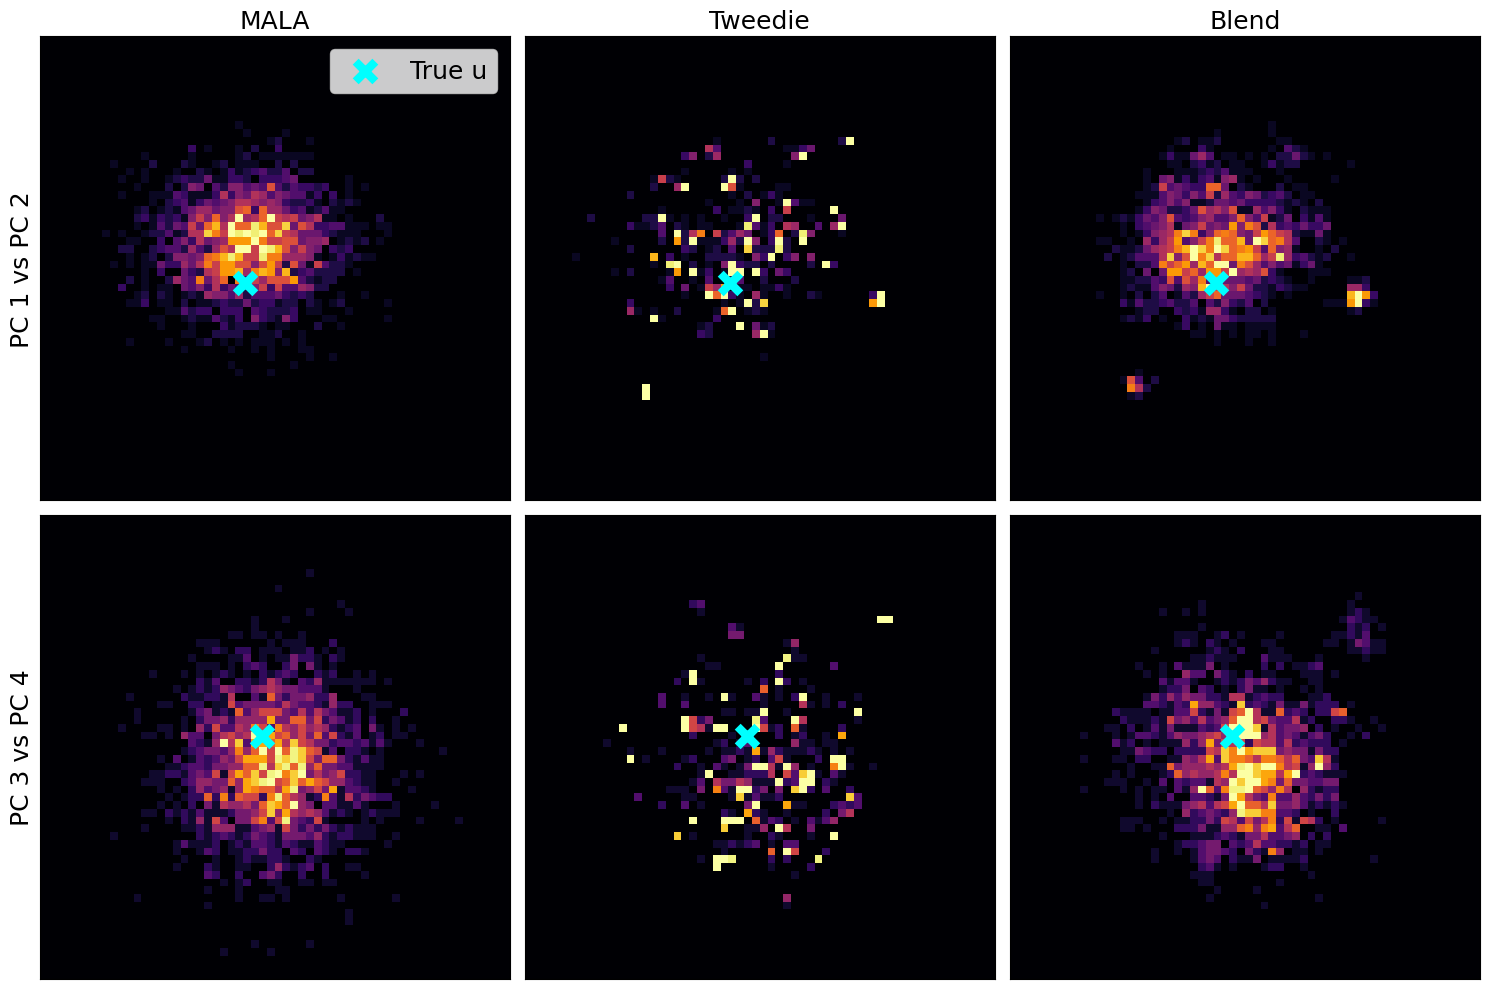

In [ ]:
import torch
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# ==========================================
# CONFIGURATION
# ==========================================
jax.config.update("jax_enable_x64", True)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Global Dtype set to: {torch.get_default_dtype()}")
print(f"Device: {device}")

# Configuration for Navier-Stokes (adapted from TAEN section 3.2)
ACTIVE_DIM = 24 # Latent dimension (KL modes)
NOISE_STD = 0.3 # 2% Noise level


# ==========================================
# 1. BRIDGE: JAX PHYSICS -> PYTORCH SAMPLER
# ==========================================

# A. Define JAX Likelihood Functions (Wrapped)
# solve_forward is assumed to be in context from the previous cell (Spectral NS)

@jax.jit
def ns_log_likelihood_jax(alpha_k, y_obs_jax, sigma):
    # Gaussian Likelihood: -||F(x) - y||^2 / 2sigma^2
    # solve_forward expects alpha_k of shape (24,)
    y_pred = solve_forward(alpha_k)
    resid = y_pred - y_obs_jax
    return -jnp.sum(resid**2) / (2 * sigma**2)

# Auto-differentiate with JAX
ns_grad_lik_jax = jax.jit(jax.grad(ns_log_likelihood_jax, argnums=0))

# Vectorize for batch processing
batch_log_lik = jax.vmap(ns_log_likelihood_jax, in_axes=(0, None, None))
batch_grad_lik = jax.vmap(ns_grad_lik_jax, in_axes=(0, None, None))

# B. PyTorch Interface Class
class NSLikelihood:
    def __init__(self, y_obs_np, sigma):
        self.y_obs_jax = jnp.array(y_obs_np)
        self.sigma = sigma

    def log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        ll_jax = batch_log_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(ll_jax), device=x_torch.device, dtype=torch.float64)

    def grad_log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        grad_jax = batch_grad_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(grad_jax), device=x_torch.device, dtype=torch.float64)

# ==========================================
# 2. PRIOR
# ==========================================
class GaussianPrior(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def sample(self, n):
        return torch.randn(n, self.dim, device=device)

    def log_prob(self, x):
        # log N(0, I)
        return -0.5 * torch.sum(x**2, dim=1) - (self.dim/2.0) * math.log(2*math.pi)

    def score0(self, x):
        # Score of N(0, I) is -x
        return -x

# ==========================================
# 3. SAMPLERS
# ==========================================
def get_posterior_snis_weights(y, t, X_ref, log_lik_ref):
    et = math.exp(-t)
    var_t = 1.0 - math.exp(-2*t)
    mus = et * X_ref
    diff = y.unsqueeze(1) - mus.unsqueeze(0)
    dists_sq = torch.sum(diff**2, dim=2)
    log_kernel = -dists_sq / (2 * var_t)
    log_unnorm = log_kernel + log_lik_ref.unsqueeze(0)
    log_norm = torch.logsumexp(log_unnorm, dim=1, keepdim=True)
    return torch.exp(log_unnorm - log_norm)

'''
def eval_blend_posterior_score(y, t, X_ref, s0_post_ref, log_lik_ref):
    if t < 1e-4: t = 1e-4
    et = math.exp(-t)
    var_t = 1.0 - math.exp(-2*t)
    inv_v = 1.0 / var_t
    eps = 1e-12

    scale_factor = 1.0 / et

    w = get_posterior_snis_weights(y, t, X_ref, log_lik_ref)

    s_kss = scale_factor * torch.einsum('mn,nd->md', w, s0_post_ref)
    mu_x = torch.einsum('mn,nd->md', w, X_ref)
    s_twd = -inv_v * (y - et * mu_x)

    w2 = w**2
    S0 = torch.sum(w2, dim=1)
    den_sn = torch.clamp(1.0 - S0, min=eps)

    a_i = scale_factor * s0_post_ref
    a_norm2 = torch.sum(a_i**2, dim=1)
    S1a = torch.mv(w2, a_norm2)
    S2a = torch.mm(w2, a_i)
    mu_a = s_kss
    mu_a_norm2 = torch.sum(mu_a**2, dim=1)
    num_Vk = S1a - 2.0 * torch.sum(mu_a * S2a, dim=1) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    w2_z = torch.mm(w2, X_ref)
    S2b = -inv_v * (y * S0.unsqueeze(1) - et * w2_z)
    y_norm2 = torch.sum(y**2, dim=1)
    z_norm2 = torch.sum(X_ref**2, dim=1)
    term1 = y_norm2 * S0
    term2 = -2.0 * et * torch.sum(y * w2_z, dim=1)
    term3 = (et**2) * torch.mv(w2, z_norm2)
    S1b = (inv_v**2) * (term1 + term2 + term3)
    mu_b = s_twd
    mu_b_norm2 = torch.sum(mu_b**2, dim=1)
    num_Vt = S1b - 2.0 * torch.sum(mu_b * S2b, dim=1) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    a_dot_z = torch.sum(a_i * X_ref, dim=1)
    Wa = S2a
    term_c1 = torch.sum(Wa * y, dim=1)
    term_c2 = torch.mv(w2, a_dot_z)
    Sab = -inv_v * (term_c1 - et * term_c2)
    num_C = Sab - torch.sum(mu_a * S2b, dim=1) - torch.sum(mu_b * S2a, dim=1) + torch.sum(mu_a * mu_b, dim=1) * S0
    C = num_C / den_sn

    denom = torch.clamp(Vk + Vt - 2.0 * C, min=eps)
    lam = (Vk - C) / denom
    lam = torch.clamp(lam, 0.0, 0.95)

    return lam.unsqueeze(1) * s_twd + (1.0 - lam.unsqueeze(1)) * s_kss

def get_score_wrapper(y, t, mode, X_ref, s0_post_ref, log_lik_ref):
    t_val = t.item() if isinstance(t, torch.Tensor) else t
    if mode == 'tweedie':
        if t_val < 1e-4: t_val = 1e-4
        et = math.exp(-t_val)
        inv_v = 1.0 / (1 - math.exp(-2*t_val))
        w = get_posterior_snis_weights(y, t_val, X_ref, log_lik_ref)
        mu_x = torch.einsum('mn,nd->md', w, X_ref)
        score = -inv_v * (y - et * mu_x)
    elif mode == 'blend_posterior':
        score = eval_blend_posterior_score(y, t_val, X_ref, s0_post_ref, log_lik_ref)
    return score
'''


# ==========================================
# 3. BATCHED SCORE COMPUTATION (NEW)
# ==========================================

def eval_score_batched(y, t, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu, batch_size=4096, mode='blend_posterior'):
    """
    Computes Tweedie or Blend Posterior score using streaming batches to avoid OOM.
    Reference data (X_ref_cpu, etc.) stays on CPU.
    """
    t_val = t.item() if isinstance(t, torch.Tensor) else t
    if t_val < 1e-4: t_val = 1e-4

    et = math.exp(-t_val)
    var_t = 1.0 - math.exp(-2 * t_val)
    inv_v = 1.0 / var_t

    # Constants for Blend
    scale_factor = 1.0 / et

    M_query = y.shape[0]
    N_ref = X_ref_cpu.shape[0]

    # --- PASS 1: Find Global Max Log-Weight (Stability) ---
    max_log_w = torch.full((M_query,), -float('inf'), device=y.device)

    for i in range(0, N_ref, batch_size):
        # Move chunk to GPU
        X_batch = X_ref_cpu[i:i+batch_size].to(y.device)
        ll_batch = log_lik_ref_cpu[i:i+batch_size].to(y.device)

        # log_weight = -||y - exp(-t)x||^2 / 2var + log_lik
        mus = et * X_batch
        dists_sq = torch.sum((y.unsqueeze(1) - mus.unsqueeze(0))**2, dim=2)
        log_w_batch = -dists_sq / (2 * var_t) + ll_batch.unsqueeze(0)

        # Update running max
        current_max, _ = torch.max(log_w_batch, dim=1)
        max_log_w = torch.max(max_log_w, current_max)

    # --- PASS 2: Accumulate Moments ---
    # Common Accumulators
    denom_Z = torch.zeros((M_query, 1), device=y.device) # sum(w_tilde)
    numer_mu_x = torch.zeros_like(y)                     # sum(w_tilde * x)

    # Blend Accumulators (Sum of w_tilde^2 * term)
    if mode == 'blend_posterior':
        numer_s0 = torch.zeros_like(y)                   # sum(w_tilde * s0)
        acc_w2 = torch.zeros((M_query, 1), device=y.device)
        acc_w2_s0_norm = torch.zeros((M_query,), device=y.device)
        acc_w2_s0 = torch.zeros_like(y)
        acc_w2_x = torch.zeros_like(y)
        acc_w2_x_norm = torch.zeros((M_query,), device=y.device)
        acc_w2_dot = torch.zeros((M_query,), device=y.device) # sum(w_tilde^2 * (s0 . x))

    for i in range(0, N_ref, batch_size):
        X_batch = X_ref_cpu[i:i+batch_size].to(y.device)
        ll_batch = log_lik_ref_cpu[i:i+batch_size].to(y.device)

        mus = et * X_batch
        dists_sq = torch.sum((y.unsqueeze(1) - mus.unsqueeze(0))**2, dim=2)
        log_w = -dists_sq / (2 * var_t) + ll_batch.unsqueeze(0)

        # Stable Unnormalized Weights: w_tilde = exp(log_w - M)
        w_batch = torch.exp(log_w - max_log_w.unsqueeze(1))

        # 1st Moment Accumulation
        denom_Z += torch.sum(w_batch, dim=1, keepdim=True)
        numer_mu_x += torch.einsum('mb,bd->md', w_batch, X_batch)

        if mode == 'blend_posterior':
            s0_batch = s0_ref_cpu[i:i+batch_size].to(y.device)
            numer_s0 += torch.einsum('mb,bd->md', w_batch, s0_batch)

            # 2nd Moment Accumulation (Squared Weights)
            w2_batch = w_batch**2
            acc_w2 += torch.sum(w2_batch, dim=1, keepdim=True)

            # Precompute batch norms/dots
            s0_sq_batch = torch.sum(s0_batch**2, dim=1)
            x_sq_batch = torch.sum(X_batch**2, dim=1)
            dot_batch = torch.sum(s0_batch * X_batch, dim=1)

            acc_w2_s0_norm += torch.mv(w2_batch, s0_sq_batch)
            acc_w2_s0 += torch.mm(w2_batch, s0_batch)
            acc_w2_x += torch.mm(w2_batch, X_batch)
            acc_w2_x_norm += torch.mv(w2_batch, x_sq_batch)
            acc_w2_dot += torch.mv(w2_batch, dot_batch)

    # --- FINALIZE / RECONSTRUCTION ---
    eps = 1e-12
    # Tweedie Score: -(y - et * E[x])/var_t
    mu_x = numer_mu_x / denom_Z
    score_twd = -inv_v * (y - et * mu_x)

    if mode == 'tweedie':
        return score_twd

    # Blend Logic Reconstruction
    # Key Identity: sum(w_norm^2 * term) = (1/Z^2) * sum(w_tilde^2 * term)
    Z_sq = denom_Z**2

    # 1. Reconstruct Expectations
    mu_a = scale_factor * (numer_s0 / denom_Z)
    mu_b = score_twd # Tweedie is mu_b

    S0 = acc_w2 / Z_sq

    # S1a = sum(w^2 ||a||^2) -> a = scale * s0 -> scale^2 * sum(w^2 ||s0||^2)
    S1a = (scale_factor**2) * (acc_w2_s0_norm.unsqueeze(1) / Z_sq)

    # S2a = sum(w^2 a) -> scale * sum(w^2 s0)
    S2a = scale_factor * (acc_w2_s0 / Z_sq)

    # Vk calculation
    den_sn = torch.clamp(1.0 - S0, min=eps)
    mu_a_norm2 = torch.sum(mu_a**2, dim=1, keepdim=True)
    num_Vk = S1a - 2.0 * torch.sum(mu_a * S2a, dim=1, keepdim=True) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    # Vt Calculation
    # Need S1b, S2b
    # S2b = -inv_v * (y * S0 - et * sum(w^2 x))
    term_w2_x = acc_w2_x / Z_sq
    S2b = -inv_v * (y * S0 - et * term_w2_x)

    # S1b logic from original:
    # y_norm2 * S0 - 2*et*sum(w^2 y.x) + et^2 sum(w^2 ||x||^2)
    # y is constant per query, pull out
    y_norm2 = torch.sum(y**2, dim=1, keepdim=True)
    y_dot_w2x = torch.sum(y * term_w2_x, dim=1, keepdim=True)
    term_w2_x_norm = acc_w2_x_norm.unsqueeze(1) / Z_sq

    S1b = (inv_v**2) * (y_norm2 * S0 - 2.0 * et * y_dot_w2x + (et**2) * term_w2_x_norm)

    mu_b_norm2 = torch.sum(mu_b**2, dim=1, keepdim=True)
    num_Vt = S1b - 2.0 * torch.sum(mu_b * S2b, dim=1, keepdim=True) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    # Covariance C Calculation
    # a dot z term -> scale * sum(w^2 s0.x)
    term_w2_dot = acc_w2_dot.unsqueeze(1) / Z_sq
    term_c2 = scale_factor * term_w2_dot

    # term_c1 = sum(S2a * y) -> dot product per row
    term_c1 = torch.sum(S2a * y, dim=1, keepdim=True)

    Sab = -inv_v * (term_c1 - et * term_c2)

    num_C = Sab - torch.sum(mu_a * S2b, dim=1, keepdim=True) - torch.sum(mu_b * S2a, dim=1, keepdim=True) + torch.sum(mu_a * mu_b, dim=1, keepdim=True) * S0
    C = num_C / den_sn

    # Lambda and Combination
    denom = torch.clamp(Vk + Vt - 2.0 * C, min=eps)
    lam = (Vk - C) / denom
    lam = torch.clamp(lam, 0.0, 0.95)

    return lam * score_twd + (1.0 - lam) * mu_a # mu_a is s_kss

def get_score_wrapper(y, t, mode, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu):
    # Call the batched version directly
    # Note: Inputs X_ref, s0_ref, log_lik_ref MUST be CPU tensors now
    score = eval_score_batched(y, t, X_ref_cpu, s0_ref_cpu, log_lik_ref_cpu, mode=mode)
    return score

def run_sampler_heun(n_samples, mode, X_ref, s0_post_ref, log_lik_ref, steps=20, dim=15):
    y = torch.randn(n_samples, dim, device=device)
    ts = torch.logspace(0.4, -3.6, steps + 1, device=device)
    for i in range(steps):
        t_cur = ts[i]
        t_next = ts[i+1]
        dt = t_cur - t_next
        s_cur = get_score_wrapper(y, t_cur, mode, X_ref, s0_post_ref, log_lik_ref)
        d_cur = y + 2 * s_cur
        z = torch.randn_like(y)
        y_hat = y + d_cur * dt + math.sqrt(2 * dt) * z
        s_next = get_score_wrapper(y_hat, t_next, mode, X_ref, s0_post_ref, log_lik_ref)
        d_next = y_hat + 2 * s_next
        drift_avg = 0.5 * (d_cur + d_next)
        y = y + drift_avg * dt + math.sqrt(2 * dt) * z
    return y

def run_mala_sampler(n_samples, prior_model, lik_model, steps=1000, dt=5e-4, burn_in=200):
    # Tuned dt=5e-4 for Navier-Stokes to ensure stability with stiffer gradients
    x = prior_model.sample(n_samples)

    log_prior = prior_model.log_prob(x)
    log_lik = lik_model.log_likelihood(x)
    score_prior = prior_model.score0(x)
    grad_lik = lik_model.grad_log_likelihood(x)

    log_post = log_prior + log_lik
    grad_log_post = score_prior + grad_lik

    accept_count = 0
    for i in range(steps):
        noise = torch.randn_like(x)
        x_prop = x + dt * grad_log_post + math.sqrt(2 * dt) * noise

        log_prior_prop = prior_model.log_prob(x_prop)
        log_lik_prop = lik_model.log_likelihood(x_prop)
        score_prior_prop = prior_model.score0(x_prop)
        grad_lik_prop = lik_model.grad_log_likelihood(x_prop)

        log_post_prop = log_prior_prop + log_lik_prop
        grad_log_post_prop = score_prior_prop + grad_lik_prop

        log_q_fwd = -torch.sum((x_prop - x - dt * grad_log_post)**2, dim=1) / (4 * dt)
        log_q_bwd = -torch.sum((x - x_prop - dt * grad_log_post_prop)**2, dim=1) / (4 * dt)

        log_alpha = log_post_prop - log_post + log_q_bwd - log_q_fwd
        accept = torch.log(torch.rand(n_samples, device=device)) < log_alpha

        x[accept] = x_prop[accept]
        log_post[accept] = log_post_prop[accept]
        grad_log_post[accept] = grad_log_post_prop[accept]

        if i >= burn_in:
            accept_count += accept.float().mean().item()

        if i % 100 == 0:
            print(f"MALA Iteration {i}/{steps}")
    print(f"MALA Acceptance: {accept_count / max(1, steps - burn_in):.2f}")
    return x

# ==========================================
# 4. EVALUATION UTILS
# ==========================================
def robust_clean_samples(samps):
    samps_np = samps.cpu().numpy() if isinstance(samps, torch.Tensor) else samps
    valid_mask = np.isfinite(samps_np).all(axis=1)
    if valid_mask.sum() < 10: return torch.tensor(samps_np[valid_mask], device=device)
    q25 = np.percentile(samps_np[valid_mask], 25, axis=0)
    q75 = np.percentile(samps_np[valid_mask], 75, axis=0)
    iqr = q75 - q25
    lower = q25 - 5.0 * iqr
    upper = q75 + 5.0 * iqr
    in_bounds = (samps_np >= lower) & (samps_np <= upper)
    valid_mask = valid_mask & in_bounds.all(axis=1)
    return torch.tensor(samps_np[valid_mask], device=device)

def sliced_wasserstein_distance(X_a, X_b, num_projections=500, p=2):
    n_a = X_a.shape[0]
    n_b = X_b.shape[0]
    if n_a > n_b:
        idx = torch.randperm(n_a)[:n_b]
        X_a = X_a[idx]
    elif n_b > n_a:
        idx = torch.randperm(n_b)[:n_a]
        X_b = X_b[idx]
    dim = X_a.shape[1]
    projections = torch.randn((num_projections, dim), device=X_a.device)
    projections = projections / torch.norm(projections, dim=1, keepdim=True)
    proj_a = torch.matmul(X_a, projections.t())
    proj_b = torch.matmul(X_b, projections.t())
    proj_a_sorted, _ = torch.sort(proj_a, dim=0)
    proj_b_sorted, _ = torch.sort(proj_b, dim=0)
    wd = torch.pow(torch.abs(proj_a_sorted - proj_b_sorted), p).mean()
    return torch.pow(wd, 1.0/p).item()

def compute_moment_errors(samples_approx, samples_ref):
    mean_approx = torch.mean(samples_approx, dim=0)
    mean_ref = torch.mean(samples_ref, dim=0)
    mean_err = torch.norm(mean_approx - mean_ref).item()

    centered_approx = samples_approx - mean_approx
    centered_ref = samples_ref - mean_ref
    cov_approx = torch.matmul(centered_approx.t(), centered_approx) / (samples_approx.shape[0] - 1)
    cov_ref = torch.matmul(centered_ref.t(), centered_ref) / (samples_ref.shape[0] - 1)
    cov_err = torch.norm(cov_approx - cov_ref).item()
    return mean_err, cov_err

def compute_mmd_rbf(X, Y, sigma=None):
    # Subsample if datasets are large to avoid O(N^2) memory issues
    n_max = 2000
    if X.shape[0] > n_max: X = X[:n_max]
    if Y.shape[0] > n_max: Y = Y[:n_max]

    # Compute pairwise distances
    dist_xx = torch.cdist(X, X, p=2)**2
    dist_yy = torch.cdist(Y, Y, p=2)**2
    dist_xy = torch.cdist(X, Y, p=2)**2

    # Median Heuristic
    if sigma is None:
        combined = torch.cat([dist_xx.view(-1), dist_yy.view(-1), dist_xy.view(-1)])
        sigma = torch.median(combined[combined > 0])
        sigma = torch.sqrt(sigma) if sigma > 0 else 1.0

    gamma = 1.0 / (2 * sigma**2)
    K_xx = torch.exp(-gamma * dist_xx)
    K_yy = torch.exp(-gamma * dist_yy)
    K_xy = torch.exp(-gamma * dist_xy)

    mmd_sq = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()

def rmse_vec(x_hat, x_true, eps=1e-12):
    # RMSE estimator for x_true
    return torch.sqrt(torch.mean((x_hat - x_true)**2)).item()

def rel_l2_vec(x_hat, x_true, eps=1e-12):
    num = torch.norm(x_hat - x_true).item()
    den = torch.norm(x_true).item() + eps
    return num / den


# --- ADDED KL AND KSD HELPERS ---


def compute_knn_entropy(samples, k=5):
    n, d = samples.shape
    if n <= k: return 0.0
    dists = torch.cdist(samples, samples)
    k_dists, _ = torch.topk(dists, k + 1, largest=False, dim=1)
    r_k = k_dists[:, k]
    log_vd = (d / 2.0) * math.log(math.pi) - torch.lgamma(torch.tensor(d / 2.0 + 1.0, device=samples.device))
    avg_log_dist = torch.log(r_k + 1e-10).mean()
    digamma_k = torch.digamma(torch.tensor(float(k), device=samples.device))
    entropy = d * avg_log_dist + math.log(n) - digamma_k + log_vd
    return entropy.item()

def compute_kl_divergence(samples, prior_model, lik_model):
    # KL(q || p) approx -H(q) - E_q[log p]
    # log p(x) = log p0(x) + log L(y|x) + const
    clean_x = robust_clean_samples(samples)
    if len(clean_x) < 20: return float('inf')

    # Entropy
    entropy = compute_knn_entropy(clean_x, k=5)

    # Cross Entropy
    with torch.no_grad():
        log_prior = prior_model.log_prob(clean_x)
        log_lik = lik_model.log_likelihood(clean_x)
        unnorm_log_post = log_prior + log_lik
        expected_log_p = torch.mean(unnorm_log_post).item()

    return -entropy - expected_log_p

def posterior_score_fn(x):
    # Gradient of log posterior: s0(x) + grad_lik(x)
    with torch.no_grad():
        s_prior = -x # Gaussian prior score
        s_lik = lik_model_ns.grad_log_likelihood(x) # Uses the global lik_model_ns
        return s_prior + s_lik

def compute_multiscale_ksd(samples, score_func, sigmas=(0.1, 0.2, 0.4, 0.8)):
    # Subsampling for O(N^2) cost
    N = samples.shape[0]
    if N > 1000:
        idx = torch.randperm(N)[:1000]
        samples = samples[idx]
        N = 1000

    X = samples
    D = X.shape[1]
    s = score_func(X)

    # diff: [N, N, D]
    diff = X.unsqueeze(1) - X.unsqueeze(0)
    # r2: [N, N]
    r2 = torch.sum(diff**2, dim=-1)

    ksd2 = 0.0
    for sigma in sigmas:
        K = torch.exp(-r2 / (2 * sigma**2))

        # Term 1: <s(x), s(y)> * k(x,y)
        sdot = torch.matmul(s, s.t())
        term1 = sdot * K

        # Term 2: <s(x), grad_y k> + <s(y), grad_x k>
        # grad_x k = - (x-y)/sigma^2 * K
        r_dot_sx = torch.einsum('ijd,id->ij', diff, s)
        r_dot_sy = torch.einsum('ijd,jd->ij', diff, s)

        # Note: diff_ij = x_i - x_j.
        # grad_xi K = -diff_ij / sigma^2 * K
        # grad_xj K = +diff_ij / sigma^2 * K
        term2 = (r_dot_sx - r_dot_sy) / (sigma**2) * K # double check sign logic standard Stein derivation

        # Term 3: div_x div_y k
        term3 = (D / (sigma**2) - r2 / (sigma**4)) * K

        U = term1 + term2 + term3
        ksd2 += torch.sum(U) / (N * N)

    return ksd2.item() / len(sigmas)


# ==========================================
# 5. PCA VISUALIZATION
# ==========================================
def plot_pca_histograms(samples_dict, alpha_true):
    # 1. Compute PCA basis from Blend Posterior (Robustly)
    blend_data = robust_clean_samples(samples_dict['blend_posterior'])

    # Center
    mean_blend = torch.mean(blend_data, dim=0)
    centered_blend = blend_data - mean_blend

    # PCA via SVD
    U, S, V = torch.svd(centered_blend)

    # Identify disjoint pairs
    pairs = [(0, 1), (2, 3)]

    methods = ['mala', 'tweedie', 'blend_posterior']
    titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for row_idx, (d1, d2) in enumerate(pairs):
        if d2 >= V.shape[1]: d1, d2 = 0, 1

        v1 = V[:, d1]
        v2 = V[:, d2]

        true_cent = torch.tensor(alpha_true, device=device) - mean_blend
        t1 = torch.dot(true_cent, v1).item()
        t2 = torch.dot(true_cent, v2).item()

        # Determine limits
        proj_blend_1 = torch.matmul(centered_blend, v1).cpu().numpy()
        proj_blend_2 = torch.matmul(centered_blend, v2).cpu().numpy()
        q01_x, q99_x = np.percentile(proj_blend_1, [1, 99])
        q01_y, q99_y = np.percentile(proj_blend_2, [1, 99])
        span_x = q99_x - q01_x
        span_y = q99_y - q01_y
        pad = 0.5
        xlims = [q01_x - pad*span_x, q99_x + pad*span_x]
        ylims = [q01_y - pad*span_y, q99_y + pad*span_y]

        for col_idx, m in enumerate(methods):
            ax = axes[row_idx, col_idx]
            ax.set_xticks([])
            ax.set_yticks([])
            if m not in samples_dict: continue

            samps = robust_clean_samples(samples_dict[m])
            centered = samps - mean_blend
            p1 = torch.matmul(centered, v1).cpu().numpy()
            p2 = torch.matmul(centered, v2).cpu().numpy()

            ax.hist2d(p1, p2, bins=60, range=[xlims, ylims], cmap='inferno', density=True, vmax = .2)
            ax.scatter(t1, t2, c='cyan', marker='x', s=200, linewidth=6, label='True u')

            if row_idx == 0: ax.set_title(f"{titles[m]}", fontsize=18)
            if col_idx == 0: ax.set_ylabel(f"PC {d1+1} vs PC {d2+1}", fontsize=18)
            if row_idx == 0 and col_idx == 0: ax.legend(fontsize=18)

    plt.tight_layout()
    plt.show()

# ==========================================
# 6. EXECUTION
# ==========================================
print(f"--- Setting up {ACTIVE_DIM}D Navier-Stokes Inverse Problem ---")

import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 1. Ground Truth
np.random.seed(42)
alpha_true_np = np.random.randn(ACTIVE_DIM)
# Scale down a bit to be in high probability mass
alpha_true_np = alpha_true_np * 0.5
y_clean = solve_forward(jnp.array(alpha_true_np))
y_obs_np = y_clean + np.random.normal(0, NOISE_STD, size=y_clean.shape)

# 2. Models
prior_model_ns = GaussianPrior(dim=ACTIVE_DIM)
lik_model_ns = NSLikelihood(y_obs_np, NOISE_STD)

# 3. Precompute
N_REF_NS = 20000
print(f"Generating {N_REF_NS} Prior Samples...")
t0 = time.time()
X_ref_ns = prior_model_ns.sample(N_REF_NS)

with torch.no_grad():
    s0_prior_ns = prior_model_ns.score0(X_ref_ns)

    # Batch Likelihood Computation
    print("Calculating Likelihoods (Batched)...")
    batch_size = 1000
    log_lik_list = []
    grad_lik_list = []

    for i in range(0, N_REF_NS, batch_size):
        batch = X_ref_ns[i:i+batch_size]
        log_lik_list.append(lik_model_ns.log_likelihood(batch))
        grad_lik_list.append(lik_model_ns.grad_log_likelihood(batch))

    log_lik_ns = torch.cat(log_lik_list)
    grad_lik_ns = torch.cat(grad_lik_list)

    s0_post_ns = s0_prior_ns + grad_lik_ns

    # --- SCALE LOGGING ---
    norm_prior = torch.norm(s0_prior_ns, dim=1).mean().item()
    norm_lik = torch.norm(grad_lik_ns, dim=1).mean().item()
    avg_ll = log_lik_ns.mean().item()

    print(f"  > Avg Prior Score Norm:       {norm_prior:.4f}")
    print(f"  > Avg Likelihood Grad Norm:   {norm_lik:.4f}")
    print(f"  > Avg Log-Likelihood Value:   {avg_ll:.4f}")

print(f"Precomputation: {time.time()-t0:.2f}s")

# 4. Run Diffusion
N_GEN_NS = 2500
samples_ns = {}
modes = ['tweedie', 'blend_posterior']
print(f"Running Diffusion (N={N_GEN_NS})...")
for m in modes:
    t_s = time.time()
    samps = run_sampler_heun(N_GEN_NS, m, X_ref_ns, s0_post_ns, log_lik_ns, steps = 500, dim=ACTIVE_DIM)
    samples_ns[m] = samps.cpu()
    print(f"{m}: {time.time()-t_s:.2f}s")

# 5. Run MCMC
print("Running MALA (Reference)...")
t_s = time.time()
# Reduced steps / Smaller dt for stiff NS
mcmc_ns = run_mala_sampler(N_GEN_NS, prior_model_ns, lik_model_ns, steps=1000, dt=0.0005, burn_in=250)
samples_ns['mala'] = mcmc_ns.cpu()
print(f"MALA: {time.time()-t_s:.2f}s")

'''
# ==========================================
# UPDATED EVALUATION LOOP
# ==========================================
print("\n=== Evaluation (metrics) ===")
print(f"{'Method':<20} | {'SW2':<10} | {'MMD':<10} | {'Mean Err':<10} | {'Cov Err':<10} | {'KSD':<10} | {'KL':<10}")
print("-" * 95)

ref_clean = robust_clean_samples(samples_ns['mala'])

for m, raw in samples_ns.items():
    samps = robust_clean_samples(raw)
    if samps.shape[0] < 50: continue

    # 1. SW2
    sw2 = sliced_wasserstein_distance(samps, ref_clean)

    # 2. MMD
    mmd = compute_mmd_rbf(samps, ref_clean)

    # 3/4. Moments
    mean_err, cov_err = compute_moment_errors(samps, ref_clean)

    # 5. KSD (Uses posterior_score_fn which uses lik_model_ns)
    ksd = compute_multiscale_ksd(samps, posterior_score_fn)

    # 6. KL
    kl = compute_kl_divergence(samps, prior_model_ns, lik_model_ns)

    print(f"{m:<20} | {sw2:<10.4f} | {mmd:<10.4f} | {mean_err:<10.4f} | {cov_err:<10.4f} | {ksd:<10.4f} | {kl:<10.4f}")
'''

# ==========================================
# UPDATED EVALUATION LOOP (LATENT / COORDINATE SPACE)
# ==========================================
print("\n=== Evaluation (latent/coordinate metrics) ===")
print(f"{'Method':<20} | {'RMSE_alpha':<10} | {'RelL2_alpha':<11} | {'MMD->MALA':<10} | {'KSD':<10} | {'KLdiag':<10}")
print("-" * 85)

ref_clean = robust_clean_samples(samples_ns['mala'])
alpha_true_t = torch.tensor(alpha_true_np, device=device, dtype=torch.float64)

metrics_ns = {}  # <-- shared dict across blocks

for m, raw in samples_ns.items():
    samps = robust_clean_samples(raw)
    if samps.shape[0] < 50:
        continue

    # Posterior mean estimator for alpha
    mean_latent = torch.mean(samps, dim=0)

    # (1) RMSE / relative L2 in latent space
    rmse_alpha = rmse_vec(mean_latent, alpha_true_t)
    rel_alpha  = rel_l2_vec(mean_latent, alpha_true_t)

    # (2) Distributional fidelity to reference posterior proxy
    mmd = compute_mmd_rbf(samps, ref_clean)

    # (NS-only) (3) KSD and (4) KL diagnostic
    ksd = compute_multiscale_ksd(samps, posterior_score_fn)
    kl  = compute_kl_divergence(samps, prior_model_ns, lik_model_ns)

    metrics_ns[m] = dict(
        mean_latent=mean_latent.detach().cpu().numpy(),  # for ambient block
        RMSE_alpha=rmse_alpha,
        RelL2_alpha=rel_alpha,
        MMD_to_MALA=mmd,
        KSD=ksd,
        KLdiag=kl,
    )

    print(f"{m:<20} | {rmse_alpha:<10.4f} | {rel_alpha:<11.4f} | {mmd:<10.4f} | {ksd:<10.4f} | {kl:<10.4f}")


# 7. Visualize
print("\n=== PCA Histograms (3x3) ===")
plot_pca_histograms(samples_ns, alpha_true_np)


<>:175: SyntaxWarning: invalid escape sequence '\o'
<>:224: SyntaxWarning: invalid escape sequence '\s'
<>:175: SyntaxWarning: invalid escape sequence '\o'
<>:224: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1463275301.py:175: SyntaxWarning: invalid escape sequence '\o'
  axes[0, 0].set_title("Ground Truth\nInitial Vorticity $\omega_0$", fontsize=20)
/tmp/ipython-input-1463275301.py:224: SyntaxWarning: invalid escape sequence '\s'
  axes[2, col].set_title(f"Uncertainty $\sigma$", fontsize=20)



=== Physical Parameter Space Metrics (Vorticity) ===
Method               | Inverse Rel. L2 Error (%)      | Forward Rel. Error  
--------------------------------------------------------------------------------
tweedie              | 99.6848                        | 0.107397            
blend_posterior      | 95.0235                        | 0.101432            
mala                 | 90.1291                        | 0.096328            

=== Ambient/physics metrics (vorticity + forward error) ===
Method               | RMSE_field   | RelL2_field  | FwdRelErr   
-----------------------------------------------------------------
tweedie              | 1.1131e-01   | 0.9968       | 1.0740e-01  
blend_posterior      | 1.0611e-01   | 0.9502       | 1.0143e-01  
mala                 | 1.0064e-01   | 0.9013       | 9.6328e-02  

=== Final NS metrics (paper-ready) ===
Method               | RMSE_a    | RMSE_w    | FwdRel    | MMD       | KSD       | KLdiag   
---------------------------------

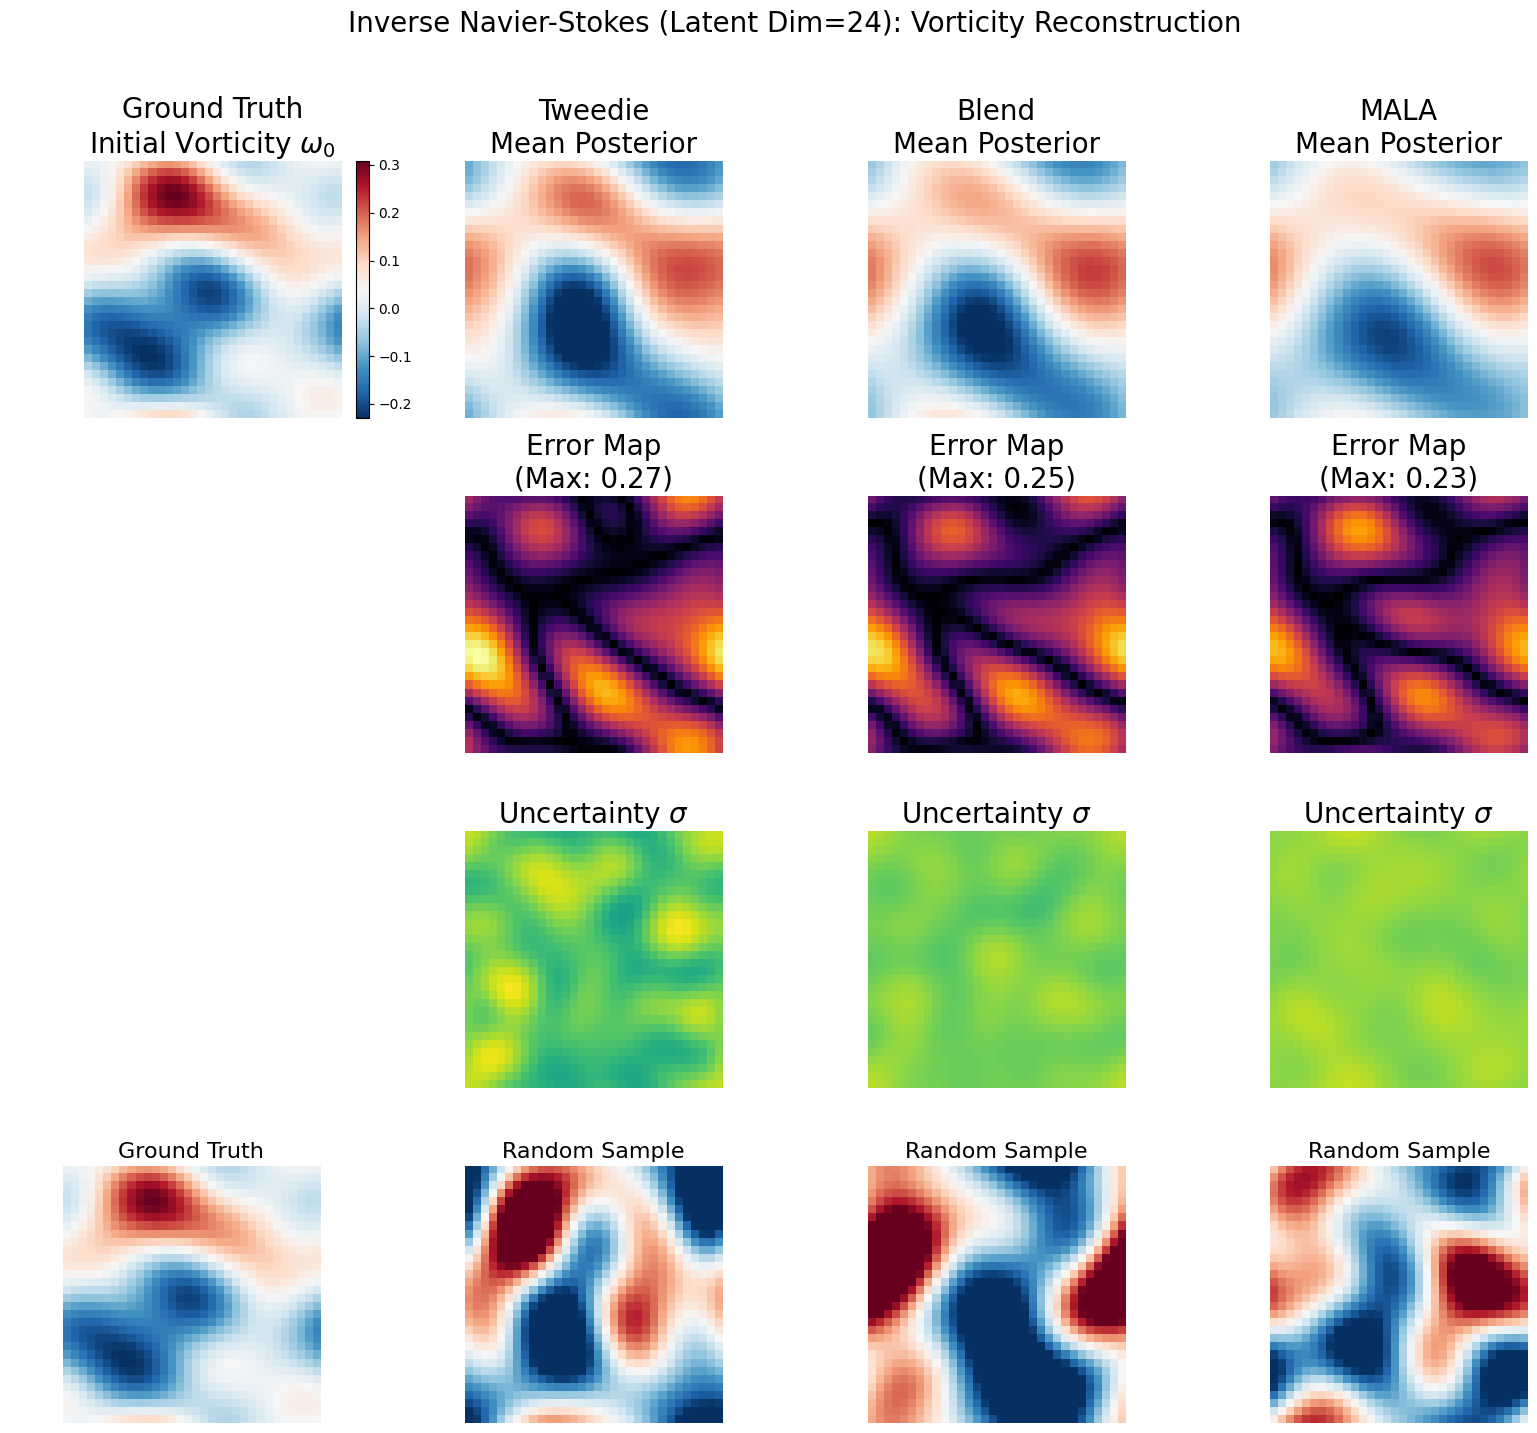

In [ ]:
# Cell 7: Scientific Visualization & Physics Metrics (Navier-Stokes)
# This cell assumes 'samples_ns', 'alpha_true_np', 'Basis', 'solve_forward', 'y_clean' are available.

import matplotlib.pyplot as plt
import numpy as np
import torch
import jax.numpy as jnp

# ==========================================
# 1. PHYSICS RECONSTRUCTION HELPERS
# ==========================================

# Ensure Basis is available as a Numpy array for visualization operations
try:
    # Basis shape is (1024, 24) for NS
    Basis_np = np.array(Basis)
except NameError:
    print("Warning: 'Basis' matrix not found. Ensure Cell 1 is run.")
    # Fallback dummy for testing flow (should not happen in correct sequence)
    Basis_np = np.random.randn(32*32, 24)

def reconstruct_vorticity(latents):
    """
    Maps latent samples (dim=24) to physical vorticity fields w(x) on 32x32 grid.
    Equation: w = Basis @ alpha
    """
    # Ensure input is numpy
    if isinstance(latents, torch.Tensor):
        latents = latents.cpu().numpy()

    # Handle single sample case
    if latents.ndim == 1:
        latents = latents[np.newaxis, :]

    # Latents: [N, 24]
    # Basis: [1024, 24]
    # w = alpha @ Basis.T -> [N, 1024]
    fields_flat = np.dot(latents, Basis_np.T)

    # Reshape to 2D Grid (32x32)
    N = latents.shape[0]
    grid_size = int(np.sqrt(fields_flat.shape[1])) # Should be 32
    fields_2d = fields_flat.reshape(N, grid_size, grid_size)

    return fields_2d

def get_valid_samples(samps_torch):
    samps = samps_torch.cpu().numpy()
    # Filter NaNs
    valid = samps[np.isfinite(samps).all(axis=1)]
    # Simple robustness check
    if len(valid) < 10: return valid
    return valid

# ==========================================
# 2. QUANTITATIVE METRICS
# ==========================================
print("\n=== Physical Parameter Space Metrics (Vorticity) ===")
print(f"{'Method':<20} | {'Inverse Rel. L2 Error (%)':<30} | {'Forward Rel. Error':<20}")
print("-" * 80)

# Reconstruct Ground Truth Field
true_field = reconstruct_vorticity(alpha_true_np)[0]
norm_true = np.linalg.norm(true_field) + 1e-9

# Calculate norm of clean observation for relative forward error
# y_clean was computed in the previous cell
norm_y_clean = np.linalg.norm(y_clean) + 1e-9

# Store mean fields for plotting
mean_fields = {}

def rmse_array(a_hat, a_true):
    return float(np.sqrt(np.mean((a_hat - a_true)**2)))



for m, samps in samples_ns.items():
    samps_clean = get_valid_samples(samps)

    if len(samps_clean) < 10:
        print(f"{m:<20} | FAILED (Unstable)")
        continue

    # 1. Compute Posterior Mean in Latent Space
    mean_latent = np.mean(samps_clean, axis=0)

    # 2. Reconstruct Mean Field (Linearity holds: Mean(Field) = Field(Mean(Latent)))
    mean_field_rec = reconstruct_vorticity(mean_latent)[0]
    mean_fields[m] = mean_field_rec

    # 3. Compute Relative L2 Error (Inverse Parameter)
    l2_error = np.linalg.norm(mean_field_rec - true_field)
    rel_error_pct = (l2_error / norm_true) * 100

    # 4. Compute Forward Error (Observation Space)
    # Map mean latent -> Observation y using the JAX solver from Cell 1
    try:
        # wrap in jnp.array and convert output to np
        y_pred_jax = solve_forward(jnp.array(mean_latent))
        y_pred = np.array(y_pred_jax)

        # Compare against ground truth noiseless observation y_clean
        fwd_err = np.linalg.norm(y_pred - y_clean) / norm_y_clean
        fwd_str = f"{fwd_err:.6f}"
    except Exception as e:
        fwd_str = "Err"

    print(f"{m:<20} | {rel_error_pct:<30.4f} | {fwd_str:<20}")


print("\n=== Ambient/physics metrics (vorticity + forward error) ===")
print(f"{'Method':<20} | {'RMSE_field':<12} | {'RelL2_field':<12} | {'FwdRelErr':<12}")
print("-" * 65)

# Ground truth field and norm
true_field = reconstruct_vorticity(alpha_true_np)[0]
norm_true = np.linalg.norm(true_field) + 1e-12

# Ensure y_clean is a numpy array for norms
y_clean_np = np.array(y_clean)
norm_y_clean = np.linalg.norm(y_clean_np) + 1e-12

for m in metrics_ns.keys():
    mean_latent = metrics_ns[m]["mean_latent"]  # numpy, shape (ACTIVE_DIM,)

    # Reconstruct posterior mean estimator for field
    mean_field_rec = reconstruct_vorticity(mean_latent)[0]

    # (1) Ambient RMSE and relative L2
    rmse_field = rmse_array(mean_field_rec, true_field)
    rel_field  = float(np.linalg.norm(mean_field_rec - true_field) / norm_true)

    # (2) Forward relative error using posterior mean estimator for alpha
    try:
        y_pred = np.array(solve_forward(jnp.array(mean_latent)))
        fwd_rel = float(np.linalg.norm(y_pred - y_clean_np) / norm_y_clean)
    except Exception:
        fwd_rel = float("nan")

    metrics_ns[m].update(dict(
        RMSE_field=rmse_field,
        RelL2_field=rel_field,
        FwdRelErr=fwd_rel,
    ))

    print(f"{m:<20} | {rmse_field:<12.4e} | {rel_field:<12.4f} | {fwd_rel:<12.4e}")

print("\n=== Final NS metrics (paper-ready) ===")
print(f"{'Method':<20} | {'RMSE_a':<9} | {'RMSE_w':<9} | {'FwdRel':<9} | {'MMD':<9} | {'KSD':<9} | {'KLdiag':<9}")
print("-" * 90)
for m, d in metrics_ns.items():
    print(f"{m:<20} | {d['RMSE_alpha']:<9.3e} | {d['RMSE_field']:<9.3e} | {d['FwdRelErr']:<9.3e} | "
          f"{d['MMD_to_MALA']:<9.3e} | {d['KSD']:<9.3e} | {d['KLdiag']:<9.3e}")


# ==========================================
# 3. QUALITATIVE VISUALIZATION
# ==========================================
print("\nVisualizing Vorticity Fields and Error Maps...")

methods_to_plot = ['tweedie', 'blend_posterior', 'mala']
titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}

# Filter active methods
methods_to_plot = [m for m in methods_to_plot if m in samples_ns]

n_cols = len(methods_to_plot) + 1
fig, axes = plt.subplots(4, n_cols, figsize=(4 * n_cols, 14))

# --- Column 0: Ground Truth ---
# Use RdBu_r colormap for vorticity (diverging)
vmin, vmax = true_field.min(), true_field.max()
im0 = axes[0, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 0].set_title("Ground Truth\nInitial Vorticity $\omega_0$", fontsize=20)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Repeat Truth for reference in bottom row
axes[3, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
axes[3, 0].set_title("Ground Truth", fontsize=16)
axes[3, 0].axis('off')

# Hide unused slots
axes[1, 0].axis('off')
axes[2, 0].axis('off')

# Calculate ranges for shared colorbars across methods
max_err = 0
max_std = 0
for m in methods_to_plot:
    if m in mean_fields:
        err = np.abs(mean_fields[m] - true_field)
        max_err = max(max_err, err.max())

        samps = get_valid_samples(samples_ns[m])[:500] # Subsample for speed
        fields = reconstruct_vorticity(samps)
        max_std = max(max_std, np.std(fields, axis=0).max())

# --- Plot Methods ---
for i, m in enumerate(methods_to_plot):
    col = i + 1
    mean_f = mean_fields[m]

    # 1. Mean Posterior Field
    im_mean = axes[0, col].imshow(mean_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
    axes[0, col].set_title(f"{titles[m]}\nMean Posterior", fontsize=20)
    axes[0, col].axis('off')
    #plt.colorbar(im_mean, ax=axes[0, col], fraction=0.046, pad=0.04)

    # 2. Absolute Error Map
    err_f = np.abs(mean_f - true_field)
    im_err = axes[1, col].imshow(err_f, cmap='inferno', origin='lower', vmin=0, vmax=max_err)
    axes[1, col].set_title(f"Error Map\n(Max: {err_f.max():.2f})", fontsize=20)
    axes[1, col].axis('off')
    #plt.colorbar(im_err, ax=axes[1, col], fraction=0.046, pad=0.04)

    # 3. Uncertainty (Std Dev)
    samps = get_valid_samples(samples_ns[m])[:1000]
    fields = reconstruct_vorticity(samps)
    std_f = np.std(fields, axis=0)

    im_std = axes[2, col].imshow(std_f, cmap='viridis', origin='lower', vmin=0, vmax=max_std)
    axes[2, col].set_title(f"Uncertainty $\sigma$", fontsize=20)
    axes[2, col].axis('off')
    plt.colorbar(im_std, ax=axes[2, col], fraction=0.046, pad=0.04)

    # 4. Random Sample
    if len(fields) > 0:
        samp_f = fields[-1]
        im_samp = axes[3, col].imshow(samp_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
        axes[3, col].set_title("Random Sample", fontsize=16)
        axes[3, col].axis('off')
        plt.colorbar(im_samp, ax=axes[3, col], fraction=0.046, pad=0.04)

plt.suptitle(f"Inverse Navier-Stokes (Latent Dim={ACTIVE_DIM}): Vorticity Reconstruction", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()




In [ ]:
'''
import torch
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# ==========================================
# CONFIGURATION
# ==========================================
jax.config.update("jax_enable_x64", True)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Global Dtype set to: {torch.get_default_dtype()}")
print(f"Device: {device}")

# Configuration for Navier-Stokes (adapted from TAEN section 3.2)
ACTIVE_DIM = 12 # Latent dimension (KL modes)
NOISE_STD = 0.25 # 2% Noise level


# ==========================================
# 1. BRIDGE: JAX PHYSICS -> PYTORCH SAMPLER
# ==========================================

# A. Define JAX Likelihood Functions (Wrapped)
# solve_forward is assumed to be in context from the previous cell (Spectral NS)

@jax.jit
def ns_log_likelihood_jax(alpha_k, y_obs_jax, sigma):
    # Gaussian Likelihood: -||F(x) - y||^2 / 2sigma^2
    # solve_forward expects alpha_k of shape (24,)
    y_pred = solve_forward(alpha_k)
    resid = y_pred - y_obs_jax
    return -jnp.sum(resid**2) / (2 * sigma**2)

# Auto-differentiate with JAX
ns_grad_lik_jax = jax.jit(jax.grad(ns_log_likelihood_jax, argnums=0))

# Vectorize for batch processing
batch_log_lik = jax.vmap(ns_log_likelihood_jax, in_axes=(0, None, None))
batch_grad_lik = jax.vmap(ns_grad_lik_jax, in_axes=(0, None, None))

# B. PyTorch Interface Class
class NSLikelihood:
    def __init__(self, y_obs_np, sigma):
        self.y_obs_jax = jnp.array(y_obs_np)
        self.sigma = sigma

    def log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        ll_jax = batch_log_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(ll_jax), device=x_torch.device, dtype=torch.float64)

    def grad_log_likelihood(self, x_torch):
        x_np = x_torch.detach().cpu().numpy()
        grad_jax = batch_grad_lik(x_np, self.y_obs_jax, self.sigma)
        return torch.tensor(np.array(grad_jax), device=x_torch.device, dtype=torch.float64)

# ==========================================
# 2. PRIOR
# ==========================================
class GaussianPrior(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def sample(self, n):
        return torch.randn(n, self.dim, device=device)

    def log_prob(self, x):
        # log N(0, I)
        return -0.5 * torch.sum(x**2, dim=1) - (self.dim/2.0) * math.log(2*math.pi)

    def score0(self, x):
        # Score of N(0, I) is -x
        return -x

# ==========================================
# 3. SAMPLERS
# ==========================================

# Global CFG Controls
CFG_SCALE_GLOBAL = 1.0  # Default 1.0 = Standard Posterior Sampling (No CFG effect)
CFG_SCHEDULE_TYPE = "constant"

def cfg_anneal_schedule(t, scale):
    """
    Returns the blending weight w(t).
    Formula: s_final = s_uncond + w(t) * (s_cond - s_uncond)
    """
    if CFG_SCHEDULE_TYPE == "linear_decay":
        # STANDARD: Decays guidance as t -> 0 (Vanishing at the end)
        return scale * t
    elif CFG_SCHEDULE_TYPE == "inverse_linear":
        # FLIPPED: Linearly increases guidance as t -> 0
        # Low guidance at high noise, Max guidance at clean data.
        # Assumes T_max approx 1.5 based on your OU config.
        T_max = 2.5
        return scale * max(0.0, 1.0 - t/T_max)
    else:
        # Constant / Default
        return scale

def get_posterior_snis_weights(y, t, X_ref, log_lik_ref):
    et = math.exp(-t)
    var_t = 1.0 - math.exp(-2*t)
    mus = et * X_ref
    diff = y.unsqueeze(1) - mus.unsqueeze(0)
    dists_sq = torch.sum(diff**2, dim=2)
    log_kernel = -dists_sq / (2 * var_t)
    log_unnorm = log_kernel + log_lik_ref.unsqueeze(0)
    log_norm = torch.logsumexp(log_unnorm, dim=1, keepdim=True)
    return torch.exp(log_unnorm - log_norm)

def eval_blend_posterior_score(y, t, X_ref, s0_post_ref, log_lik_ref):
    if t < 1e-4: t = 1e-4
    et = math.exp(-t)
    var_t = 1.0 - math.exp(-2*t)
    inv_v = 1.0 / var_t
    eps = 1e-12

    scale_factor = 1.0 / et

    w = get_posterior_snis_weights(y, t, X_ref, log_lik_ref)

    s_kss = scale_factor * torch.einsum('mn,nd->md', w, s0_post_ref)
    mu_x = torch.einsum('mn,nd->md', w, X_ref)
    s_twd = -inv_v * (y - et * mu_x)

    w2 = w**2
    S0 = torch.sum(w2, dim=1)
    den_sn = torch.clamp(1.0 - S0, min=eps)

    a_i = scale_factor * s0_post_ref
    a_norm2 = torch.sum(a_i**2, dim=1)
    S1a = torch.mv(w2, a_norm2)
    S2a = torch.mm(w2, a_i)
    mu_a = s_kss
    mu_a_norm2 = torch.sum(mu_a**2, dim=1)
    num_Vk = S1a - 2.0 * torch.sum(mu_a * S2a, dim=1) + mu_a_norm2 * S0
    Vk = num_Vk / den_sn

    w2_z = torch.mm(w2, X_ref)
    S2b = -inv_v * (y * S0.unsqueeze(1) - et * w2_z)
    y_norm2 = torch.sum(y**2, dim=1)
    z_norm2 = torch.sum(X_ref**2, dim=1)
    term1 = y_norm2 * S0
    term2 = -2.0 * et * torch.sum(y * w2_z, dim=1)
    term3 = (et**2) * torch.mv(w2, z_norm2)
    S1b = (inv_v**2) * (term1 + term2 + term3)
    mu_b = s_twd
    mu_b_norm2 = torch.sum(mu_b**2, dim=1)
    num_Vt = S1b - 2.0 * torch.sum(mu_b * S2b, dim=1) + mu_b_norm2 * S0
    Vt = num_Vt / den_sn

    a_dot_z = torch.sum(a_i * X_ref, dim=1)
    Wa = S2a
    term_c1 = torch.sum(Wa * y, dim=1)
    term_c2 = torch.mv(w2, a_dot_z)
    Sab = -inv_v * (term_c1 - et * term_c2)
    num_C = Sab - torch.sum(mu_a * S2b, dim=1) - torch.sum(mu_b * S2a, dim=1) + torch.sum(mu_a * mu_b, dim=1) * S0
    C = num_C / den_sn

    denom = torch.clamp(Vk + Vt - 2.0 * C, min=eps)
    lam = (Vk - C) / denom
    lam = torch.clamp(lam, 0.0, 0.95)

    return lam.unsqueeze(1) * s_twd + (1.0 - lam.unsqueeze(1)) * s_kss

def get_score_wrapper(y, t, mode, X_ref, s0_post_ref, log_lik_ref, s0_prior_ref=None):
    """
    Wrapper that applies Classifier-Free Guidance (CFG).

    Args:
        s0_prior_ref: (Optional) The scores of the prior samples.
                      Required for mathematically correct unconditional Blend scores.
                      If None, falls back to s0_post_ref.
    """
    t_val = t.item() if isinstance(t, torch.Tensor) else t

    # 1. Compute Conditional Score (Posterior)
    if mode == 'tweedie':
        if t_val < 1e-4: t_val = 1e-4
        et = math.exp(-t_val)
        inv_v = 1.0 / (1 - math.exp(-2*t_val))
        w = get_posterior_snis_weights(y, t_val, X_ref, log_lik_ref)
        mu_x = torch.einsum('mn,nd->md', w, X_ref)
        s_cond = -inv_v * (y - et * mu_x)
    elif mode == 'blend_posterior':
        s_cond = eval_blend_posterior_score(y, t_val, X_ref, s0_post_ref, log_lik_ref)

    # 2. Check if CFG is active
    # Calculate current guidance strength w(t)
    w_t = cfg_anneal_schedule(t_val, CFG_SCALE_GLOBAL)

    # Optimization: If w(t) == 1.0 (Standard Posterior), skip unconditional calc
    if abs(w_t - 1.0) < 1e-6:
        return s_cond

    # 3. Compute Unconditional Score (Prior)
    # Zeros out likelihood influence
    zeros_lik = torch.zeros_like(log_lik_ref)

    # For Blend, we ideally need the PRIOR score s0_prior, not s0_post
    s0_uncond = s0_prior_ref if s0_prior_ref is not None else s0_post_ref

    if mode == 'tweedie':
        if t_val < 1e-4: t_val = 1e-4
        et = math.exp(-t_val)
        inv_v = 1.0 / (1 - math.exp(-2*t_val))
        # Use zeros_lik for unconditional weights
        w_uncond = get_posterior_snis_weights(y, t_val, X_ref, zeros_lik)
        mu_x_uncond = torch.einsum('mn,nd->md', w_uncond, X_ref)
        s_uncond = -inv_v * (y - et * mu_x_uncond)

    elif mode == 'blend_posterior':
        # Use zeros_lik and s0_uncond
        s_uncond = eval_blend_posterior_score(y, t_val, X_ref, s0_uncond, zeros_lik)

    # 4. Apply CFG Formula
    # s = s_uncond + w(t) * (s_cond - s_uncond)
    return s_uncond + w_t * (s_cond - s_uncond)

def run_sampler_heun(n_samples, mode, X_ref, s0_post_ref, log_lik_ref, steps=20, dim=15):
    y = torch.randn(n_samples, dim, device=device)
    ts = torch.logspace(0.4, -3.6, steps + 1, device=device)
    for i in range(steps):
        t_cur = ts[i]
        t_next = ts[i+1]
        dt = t_cur - t_next
        s_cur = get_score_wrapper(y, t_cur, mode, X_ref, s0_post_ref, log_lik_ref)
        d_cur = y + 2 * s_cur
        z = torch.randn_like(y)
        y_hat = y + d_cur * dt + math.sqrt(2 * dt) * z
        s_next = get_score_wrapper(y_hat, t_next, mode, X_ref, s0_post_ref, log_lik_ref)
        d_next = y_hat + 2 * s_next
        drift_avg = 0.5 * (d_cur + d_next)
        y = y + drift_avg * dt + math.sqrt(2 * dt) * z
    return y

def run_mala_sampler(n_samples, prior_model, lik_model, steps=1000, dt=5e-4, burn_in=200):
    # Tuned dt=5e-4 for Navier-Stokes to ensure stability with stiffer gradients
    x = prior_model.sample(n_samples)

    log_prior = prior_model.log_prob(x)
    log_lik = lik_model.log_likelihood(x)
    score_prior = prior_model.score0(x)
    grad_lik = lik_model.grad_log_likelihood(x)

    log_post = log_prior + log_lik
    grad_log_post = score_prior + grad_lik

    accept_count = 0
    for i in range(steps):
        noise = torch.randn_like(x)
        x_prop = x + dt * grad_log_post + math.sqrt(2 * dt) * noise

        log_prior_prop = prior_model.log_prob(x_prop)
        log_lik_prop = lik_model.log_likelihood(x_prop)
        score_prior_prop = prior_model.score0(x_prop)
        grad_lik_prop = lik_model.grad_log_likelihood(x_prop)

        log_post_prop = log_prior_prop + log_lik_prop
        grad_log_post_prop = score_prior_prop + grad_lik_prop

        log_q_fwd = -torch.sum((x_prop - x - dt * grad_log_post)**2, dim=1) / (4 * dt)
        log_q_bwd = -torch.sum((x - x_prop - dt * grad_log_post_prop)**2, dim=1) / (4 * dt)

        log_alpha = log_post_prop - log_post + log_q_bwd - log_q_fwd
        accept = torch.log(torch.rand(n_samples, device=device)) < log_alpha

        x[accept] = x_prop[accept]
        log_post[accept] = log_post_prop[accept]
        grad_log_post[accept] = grad_log_post_prop[accept]

        if i >= burn_in:
            accept_count += accept.float().mean().item()

        if i % 100 == 0:
            print(f"MALA Iteration {i}/{steps}")
    print(f"MALA Acceptance: {accept_count / max(1, steps - burn_in):.2f}")
    return x

# ==========================================
# 4. EVALUATION UTILS
# ==========================================
def robust_clean_samples(samps):
    samps_np = samps.cpu().numpy() if isinstance(samps, torch.Tensor) else samps
    valid_mask = np.isfinite(samps_np).all(axis=1)
    if valid_mask.sum() < 10: return torch.tensor(samps_np[valid_mask], device=device)
    q25 = np.percentile(samps_np[valid_mask], 25, axis=0)
    q75 = np.percentile(samps_np[valid_mask], 75, axis=0)
    iqr = q75 - q25
    lower = q25 - 5.0 * iqr
    upper = q75 + 5.0 * iqr
    in_bounds = (samps_np >= lower) & (samps_np <= upper)
    valid_mask = valid_mask & in_bounds.all(axis=1)
    return torch.tensor(samps_np[valid_mask], device=device)

def sliced_wasserstein_distance(X_a, X_b, num_projections=500, p=2):
    n_a = X_a.shape[0]
    n_b = X_b.shape[0]
    if n_a > n_b:
        idx = torch.randperm(n_a)[:n_b]
        X_a = X_a[idx]
    elif n_b > n_a:
        idx = torch.randperm(n_b)[:n_a]
        X_b = X_b[idx]
    dim = X_a.shape[1]
    projections = torch.randn((num_projections, dim), device=X_a.device)
    projections = projections / torch.norm(projections, dim=1, keepdim=True)
    proj_a = torch.matmul(X_a, projections.t())
    proj_b = torch.matmul(X_b, projections.t())
    proj_a_sorted, _ = torch.sort(proj_a, dim=0)
    proj_b_sorted, _ = torch.sort(proj_b, dim=0)
    wd = torch.pow(torch.abs(proj_a_sorted - proj_b_sorted), p).mean()
    return torch.pow(wd, 1.0/p).item()

def compute_moment_errors(samples_approx, samples_ref):
    mean_approx = torch.mean(samples_approx, dim=0)
    mean_ref = torch.mean(samples_ref, dim=0)
    mean_err = torch.norm(mean_approx - mean_ref).item()

    centered_approx = samples_approx - mean_approx
    centered_ref = samples_ref - mean_ref
    cov_approx = torch.matmul(centered_approx.t(), centered_approx) / (samples_approx.shape[0] - 1)
    cov_ref = torch.matmul(centered_ref.t(), centered_ref) / (samples_ref.shape[0] - 1)
    cov_err = torch.norm(cov_approx - cov_ref).item()
    return mean_err, cov_err

def compute_mmd_rbf(X, Y, sigma=None):
    # Subsample if datasets are large to avoid O(N^2) memory issues
    n_max = 2000
    if X.shape[0] > n_max: X = X[:n_max]
    if Y.shape[0] > n_max: Y = Y[:n_max]

    # Compute pairwise distances
    dist_xx = torch.cdist(X, X, p=2)**2
    dist_yy = torch.cdist(Y, Y, p=2)**2
    dist_xy = torch.cdist(X, Y, p=2)**2

    # Median Heuristic
    if sigma is None:
        combined = torch.cat([dist_xx.view(-1), dist_yy.view(-1), dist_xy.view(-1)])
        sigma = torch.median(combined[combined > 0])
        sigma = torch.sqrt(sigma) if sigma > 0 else 1.0

    gamma = 1.0 / (2 * sigma**2)
    K_xx = torch.exp(-gamma * dist_xx)
    K_yy = torch.exp(-gamma * dist_yy)
    K_xy = torch.exp(-gamma * dist_xy)

    mmd_sq = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return torch.sqrt(torch.clamp(mmd_sq, min=0.0)).item()

# --- ADDED KL AND KSD HELPERS ---

def compute_knn_entropy(samples, k=5):
    n, d = samples.shape
    if n <= k: return 0.0
    dists = torch.cdist(samples, samples)
    k_dists, _ = torch.topk(dists, k + 1, largest=False, dim=1)
    r_k = k_dists[:, k]
    log_vd = (d / 2.0) * math.log(math.pi) - torch.lgamma(torch.tensor(d / 2.0 + 1.0, device=samples.device))
    avg_log_dist = torch.log(r_k + 1e-10).mean()
    digamma_k = torch.digamma(torch.tensor(float(k), device=samples.device))
    entropy = d * avg_log_dist + math.log(n) - digamma_k + log_vd
    return entropy.item()

def compute_kl_divergence(samples, prior_model, lik_model):
    # KL(q || p) approx -H(q) - E_q[log p]
    # log p(x) = log p0(x) + log L(y|x) + const
    clean_x = robust_clean_samples(samples)
    if len(clean_x) < 20: return float('inf')

    # Entropy
    entropy = compute_knn_entropy(clean_x, k=5)

    # Cross Entropy
    with torch.no_grad():
        log_prior = prior_model.log_prob(clean_x)
        log_lik = lik_model.log_likelihood(clean_x)
        unnorm_log_post = log_prior + log_lik
        expected_log_p = torch.mean(unnorm_log_post).item()

    return -entropy - expected_log_p

def posterior_score_fn(x):
    # Gradient of log posterior: s0(x) + grad_lik(x)
    with torch.no_grad():
        s_prior = -x # Gaussian prior score
        s_lik = lik_model_ns.grad_log_likelihood(x) # Uses the global lik_model_ns
        return s_prior + s_lik

def compute_multiscale_ksd(samples, score_func, sigmas=(0.1, 0.2, 0.4, 0.8)):
    # Subsampling for O(N^2) cost
    N = samples.shape[0]
    if N > 1000:
        idx = torch.randperm(N)[:1000]
        samples = samples[idx]
        N = 1000

    X = samples
    D = X.shape[1]
    s = score_func(X)

    # diff: [N, N, D]
    diff = X.unsqueeze(1) - X.unsqueeze(0)
    # r2: [N, N]
    r2 = torch.sum(diff**2, dim=-1)

    ksd2 = 0.0
    for sigma in sigmas:
        K = torch.exp(-r2 / (2 * sigma**2))

        # Term 1: <s(x), s(y)> * k(x,y)
        sdot = torch.matmul(s, s.t())
        term1 = sdot * K

        # Term 2: <s(x), grad_y k> + <s(y), grad_x k>
        # grad_x k = - (x-y)/sigma^2 * K
        r_dot_sx = torch.einsum('ijd,id->ij', diff, s)
        r_dot_sy = torch.einsum('ijd,jd->ij', diff, s)

        # Note: diff_ij = x_i - x_j.
        # grad_xi K = -diff_ij / sigma^2 * K
        # grad_xj K = +diff_ij / sigma^2 * K
        term2 = (r_dot_sx - r_dot_sy) / (sigma**2) * K # double check sign logic standard Stein derivation

        # Term 3: div_x div_y k
        term3 = (D / (sigma**2) - r2 / (sigma**4)) * K

        U = term1 + term2 + term3
        ksd2 += torch.sum(U) / (N * N)

    return ksd2.item() / len(sigmas)


# ==========================================
# 5. PCA VISUALIZATION
# ==========================================
def plot_pca_histograms(samples_dict, alpha_true):
    # 1. Compute PCA basis from Blend Posterior (Robustly)
    blend_data = robust_clean_samples(samples_dict['blend_posterior'])

    # Center
    mean_blend = torch.mean(blend_data, dim=0)
    centered_blend = blend_data - mean_blend

    # PCA via SVD
    U, S, V = torch.svd(centered_blend)

    # Identify disjoint pairs
    pairs = [(0, 1), (2, 3)]

    methods = ['mala', 'tweedie', 'blend_posterior']
    titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for row_idx, (d1, d2) in enumerate(pairs):
        if d2 >= V.shape[1]: d1, d2 = 0, 1

        v1 = V[:, d1]
        v2 = V[:, d2]

        true_cent = torch.tensor(alpha_true, device=device) - mean_blend
        t1 = torch.dot(true_cent, v1).item()
        t2 = torch.dot(true_cent, v2).item()

        # Determine limits
        proj_blend_1 = torch.matmul(centered_blend, v1).cpu().numpy()
        proj_blend_2 = torch.matmul(centered_blend, v2).cpu().numpy()
        q01_x, q99_x = np.percentile(proj_blend_1, [1, 99])
        q01_y, q99_y = np.percentile(proj_blend_2, [1, 99])
        span_x = q99_x - q01_x
        span_y = q99_y - q01_y
        pad = 0.5
        xlims = [q01_x - pad*span_x, q99_x + pad*span_x]
        ylims = [q01_y - pad*span_y, q99_y + pad*span_y]

        for col_idx, m in enumerate(methods):
            ax = axes[row_idx, col_idx]
            if m not in samples_dict: continue

            samps = robust_clean_samples(samples_dict[m])
            centered = samps - mean_blend
            p1 = torch.matmul(centered, v1).cpu().numpy()
            p2 = torch.matmul(centered, v2).cpu().numpy()

            ax.hist2d(p1, p2, bins=60, range=[xlims, ylims], cmap='inferno', density=True, vmax = .2)
            ax.scatter(t1, t2, c='cyan', marker='x', s=200, label='True u')

            if row_idx == 0: ax.set_title(f"{titles[m]}", fontsize=20)
            if col_idx == 0: ax.set_ylabel(f"PC {d1+1} vs PC {d2+1}", fontsize=12)
            if row_idx == 0 and col_idx == 0: ax.legend()

    plt.tight_layout()
    plt.show()

# ==========================================
# 6. EXECUTION
# ==========================================
print(f"--- Setting up {ACTIVE_DIM}D Navier-Stokes Inverse Problem ---")

import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 1. Ground Truth
np.random.seed(42)
alpha_true_np = np.random.randn(ACTIVE_DIM)
# Scale down a bit to be in high probability mass
alpha_true_np = alpha_true_np * 0.5
y_clean = solve_forward(jnp.array(alpha_true_np))
y_obs_np = y_clean + np.random.normal(0, NOISE_STD, size=y_clean.shape)

# 2. Models
prior_model_ns = GaussianPrior(dim=ACTIVE_DIM)
lik_model_ns = NSLikelihood(y_obs_np, NOISE_STD)

# 3. Precompute
N_REF_NS = 28000
print(f"Generating {N_REF_NS} Prior Samples...")
t0 = time.time()
X_ref_ns = prior_model_ns.sample(N_REF_NS)

with torch.no_grad():
    s0_prior_ns = prior_model_ns.score0(X_ref_ns)

    # Batch Likelihood Computation
    print("Calculating Likelihoods (Batched)...")
    batch_size = 1000
    log_lik_list = []
    grad_lik_list = []

    for i in range(0, N_REF_NS, batch_size):
        batch = X_ref_ns[i:i+batch_size]
        log_lik_list.append(lik_model_ns.log_likelihood(batch))
        grad_lik_list.append(lik_model_ns.grad_log_likelihood(batch))

    log_lik_ns = torch.cat(log_lik_list)
    grad_lik_ns = torch.cat(grad_lik_list)

    s0_post_ns = s0_prior_ns + grad_lik_ns

    # --- SCALE LOGGING ---
    norm_prior = torch.norm(s0_prior_ns, dim=1).mean().item()
    norm_lik = torch.norm(grad_lik_ns, dim=1).mean().item()
    avg_ll = log_lik_ns.mean().item()

    print(f"  > Avg Prior Score Norm:       {norm_prior:.4f}")
    print(f"  > Avg Likelihood Grad Norm:   {norm_lik:.4f}")
    print(f"  > Avg Log-Likelihood Value:   {avg_ll:.4f}")

print(f"Precomputation: {time.time()-t0:.2f}s")

# 4. Run Diffusion
N_GEN_NS = 500
samples_ns = {}
modes = ['tweedie', 'blend_posterior']
print(f"Running Diffusion (N={N_GEN_NS})...")
for m in modes:
    t_s = time.time()
    samps = run_sampler_heun(N_GEN_NS, m, X_ref_ns, s0_post_ns, log_lik_ns, steps = 500, dim=ACTIVE_DIM)
    samples_ns[m] = samps.cpu()
    print(f"{m}: {time.time()-t_s:.2f}s")

# 5. Run MCMC
print("Running MALA (Reference)...")
t_s = time.time()
# Reduced steps / Smaller dt for stiff NS
mcmc_ns = run_mala_sampler(N_GEN_NS, prior_model_ns, lik_model_ns, steps=1000, dt=0.0005, burn_in=300)
samples_ns['mala'] = mcmc_ns.cpu()
print(f"MALA: {time.time()-t_s:.2f}s")

# ==========================================
# UPDATED EVALUATION LOOP
# ==========================================
print("\n=== Evaluation (metrics) ===")
print(f"{'Method':<20} | {'SW2':<10} | {'MMD':<10} | {'Mean Err':<10} | {'Cov Err':<10} | {'KSD':<10} | {'KL':<10}")
print("-" * 95)

ref_clean = robust_clean_samples(samples_ns['mala'])

for m, raw in samples_ns.items():
    samps = robust_clean_samples(raw)
    if samps.shape[0] < 50: continue

    # 1. SW2
    sw2 = sliced_wasserstein_distance(samps, ref_clean)

    # 2. MMD
    mmd = compute_mmd_rbf(samps, ref_clean)

    # 3/4. Moments
    mean_err, cov_err = compute_moment_errors(samps, ref_clean)

    # 5. KSD (Uses posterior_score_fn which uses lik_model_ns)
    ksd = compute_multiscale_ksd(samps, posterior_score_fn)

    # 6. KL
    kl = compute_kl_divergence(samps, prior_model_ns, lik_model_ns)

    print(f"{m:<20} | {sw2:<10.4f} | {mmd:<10.4f} | {mean_err:<10.4f} | {cov_err:<10.4f} | {ksd:<10.4f} | {kl:<10.4f}")

# 7. Visualize
print("\n=== PCA Histograms (3x3) ===")
plot_pca_histograms(samples_ns, alpha_true_np)
'''

'\nimport torch\nimport jax\nimport jax.numpy as jnp\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport time\nimport math\n\n# ==========================================\n# CONFIGURATION\n# ==========================================\njax.config.update("jax_enable_x64", True)\ntorch.set_default_dtype(torch.float64)\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nprint(f"Global Dtype set to: {torch.get_default_dtype()}")\nprint(f"Device: {device}")\n\n# Configuration for Navier-Stokes (adapted from TAEN section 3.2)\nACTIVE_DIM = 12 # Latent dimension (KL modes)\nNOISE_STD = 0.25 # 2% Noise level\n\n\n# ==========================================\n# 1. BRIDGE: JAX PHYSICS -> PYTORCH SAMPLER\n# ==========================================\n\n# A. Define JAX Likelihood Functions (Wrapped)\n# solve_forward is assumed to be in context from the previous cell (Spectral NS)\n\n@jax.jit\ndef ns_log_likelihood_jax(alpha_k, y_obs_jax, sigma):\n    # Gaussian Like

In [ ]:
'''
# Cell 7: Scientific Visualization & Physics Metrics (Navier-Stokes)
# This cell assumes 'samples_ns', 'alpha_true_np', 'Basis', 'solve_forward', 'y_clean' are available.

import matplotlib.pyplot as plt
import numpy as np
import torch
import jax.numpy as jnp

# ==========================================
# 1. PHYSICS RECONSTRUCTION HELPERS
# ==========================================

# Ensure Basis is available as a Numpy array for visualization operations
try:
    # Basis shape is (1024, 24) for NS
    Basis_np = np.array(Basis)
except NameError:
    print("Warning: 'Basis' matrix not found. Ensure Cell 1 is run.")
    # Fallback dummy for testing flow (should not happen in correct sequence)
    Basis_np = np.random.randn(32*32, 24)

def reconstruct_vorticity(latents):
    """
    Maps latent samples (dim=24) to physical vorticity fields w(x) on 32x32 grid.
    Equation: w = Basis @ alpha
    """
    # Ensure input is numpy
    if isinstance(latents, torch.Tensor):
        latents = latents.cpu().numpy()

    # Handle single sample case
    if latents.ndim == 1:
        latents = latents[np.newaxis, :]

    # Latents: [N, 24]
    # Basis: [1024, 24]
    # w = alpha @ Basis.T -> [N, 1024]
    fields_flat = np.dot(latents, Basis_np.T)

    # Reshape to 2D Grid (32x32)
    N = latents.shape[0]
    grid_size = int(np.sqrt(fields_flat.shape[1])) # Should be 32
    fields_2d = fields_flat.reshape(N, grid_size, grid_size)

    return fields_2d

def get_valid_samples(samps_torch):
    samps = samps_torch.cpu().numpy()
    # Filter NaNs
    valid = samps[np.isfinite(samps).all(axis=1)]
    # Simple robustness check
    if len(valid) < 10: return valid
    return valid

# ==========================================
# 2. QUANTITATIVE METRICS
# ==========================================
print("\n=== Physical Parameter Space Metrics (Vorticity) ===")
print(f"{'Method':<20} | {'Inverse Rel. L2 Error (%)':<30} | {'Forward Rel. Error':<20}")
print("-" * 80)

# Reconstruct Ground Truth Field
true_field = reconstruct_vorticity(alpha_true_np)[0]
norm_true = np.linalg.norm(true_field) + 1e-9

# Calculate norm of clean observation for relative forward error
# y_clean was computed in the previous cell
norm_y_clean = np.linalg.norm(y_clean) + 1e-9

# Store mean fields for plotting
mean_fields = {}

for m, samps in samples_ns.items():
    samps_clean = get_valid_samples(samps)

    if len(samps_clean) < 10:
        print(f"{m:<20} | FAILED (Unstable)")
        continue

    # 1. Compute Posterior Mean in Latent Space
    mean_latent = np.mean(samps_clean, axis=0)

    # 2. Reconstruct Mean Field (Linearity holds: Mean(Field) = Field(Mean(Latent)))
    mean_field_rec = reconstruct_vorticity(mean_latent)[0]
    mean_fields[m] = mean_field_rec

    # 3. Compute Relative L2 Error (Inverse Parameter)
    l2_error = np.linalg.norm(mean_field_rec - true_field)
    rel_error_pct = (l2_error / norm_true) * 100

    # 4. Compute Forward Error (Observation Space)
    # Map mean latent -> Observation y using the JAX solver from Cell 1
    try:
        # wrap in jnp.array and convert output to np
        y_pred_jax = solve_forward(jnp.array(mean_latent))
        y_pred = np.array(y_pred_jax)

        # Compare against ground truth noiseless observation y_clean
        fwd_err = np.linalg.norm(y_pred - y_clean) / norm_y_clean
        fwd_str = f"{fwd_err:.6f}"
    except Exception as e:
        fwd_str = "Err"

    print(f"{m:<20} | {rel_error_pct:<30.4f} | {fwd_str:<20}")

# === NEW METRIC: Deviation from MALA (Ambient Field Difference) ===
if 'mala' in mean_fields:
    print("\n=== Deviation from MALA Reference (Ambient Field) ===")
    print(f"{'Method':<20} | {'Rel. L2 Diff to MALA (%)':<30}")
    print("-" * 60)

    mala_field = mean_fields['mala']
    norm_mala = np.linalg.norm(mala_field) + 1e-9

    for m, field in mean_fields.items():
        if m == 'mala': continue

        # Calculate L2 difference between the method's mean field and MALA's mean field
        diff_field = field - mala_field
        l2_diff = np.linalg.norm(diff_field)

        # Relative percentage
        rel_diff_pct = (l2_diff / norm_mala) * 100

        print(f"{m:<20} | {rel_diff_pct:<30.4f}")
else:
    print("\n[Info] MALA not found in results; skipping MALA reference comparison.")


# ==========================================
# 3. QUALITATIVE VISUALIZATION
# ==========================================
print("\nVisualizing Vorticity Fields and Error Maps...")

methods_to_plot = ['tweedie', 'blend_posterior', 'mala']
titles = {'mala': 'MALA', 'tweedie': 'Tweedie', 'blend_posterior': 'Blend'}

# Filter active methods
methods_to_plot = [m for m in methods_to_plot if m in samples_ns]

n_cols = len(methods_to_plot) + 1
fig, axes = plt.subplots(4, n_cols, figsize=(4 * n_cols, 14))

# --- Column 0: Ground Truth ---
# Use RdBu_r colormap for vorticity (diverging)
vmin, vmax = true_field.min(), true_field.max()
im0 = axes[0, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
axes[0, 0].set_title("Ground Truth\nInitial Vorticity $\omega_0$", fontsize=16)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Repeat Truth for reference in bottom row
axes[3, 0].imshow(true_field, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
axes[3, 0].set_title("Ground Truth", fontsize=16)
axes[3, 0].axis('off')

# Hide unused slots
axes[1, 0].axis('off')
axes[2, 0].axis('off')

# Calculate ranges for shared colorbars across methods
max_err = 0
max_std = 0
for m in methods_to_plot:
    if m in mean_fields:
        err = np.abs(mean_fields[m] - true_field)
        max_err = max(max_err, err.max())

        samps = get_valid_samples(samples_ns[m])[:500] # Subsample for speed
        fields = reconstruct_vorticity(samps)
        max_std = max(max_std, np.std(fields, axis=0).max())

# --- Plot Methods ---
for i, m in enumerate(methods_to_plot):
    col = i + 1
    mean_f = mean_fields[m]

    # 1. Mean Posterior Field
    im_mean = axes[0, col].imshow(mean_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
    axes[0, col].set_title(f"{titles[m]}\nMean Posterior", fontsize=16)
    axes[0, col].axis('off')
    plt.colorbar(im_mean, ax=axes[0, col], fraction=0.046, pad=0.04)

    # 2. Absolute Error Map
    err_f = np.abs(mean_f - true_field)
    im_err = axes[1, col].imshow(err_f, cmap='inferno', origin='lower', vmin=0, vmax=max_err)
    axes[1, col].set_title(f"Error Map\n(Max: {err_f.max():.2f})", fontsize=16)
    axes[1, col].axis('off')
    plt.colorbar(im_err, ax=axes[1, col], fraction=0.046, pad=0.04)

    # 3. Uncertainty (Std Dev)
    samps = get_valid_samples(samples_ns[m])[:1000]
    fields = reconstruct_vorticity(samps)
    std_f = np.std(fields, axis=0)

    im_std = axes[2, col].imshow(std_f, cmap='viridis', origin='lower', vmin=0, vmax=max_std)
    axes[2, col].set_title(f"Uncertainty $\sigma$", fontsize=16)
    axes[2, col].axis('off')
    plt.colorbar(im_std, ax=axes[2, col], fraction=0.046, pad=0.04)

    # 4. Random Sample
    if len(fields) > 0:
        samp_f = fields[-1]
        im_samp = axes[3, col].imshow(samp_f, cmap='RdBu_r', origin='lower', vmin=vmin, vmax=vmax)
        axes[3, col].set_title("Random Sample", fontsize=16)
        axes[3, col].axis('off')
        plt.colorbar(im_samp, ax=axes[3, col], fraction=0.046, pad=0.04)

plt.suptitle(f"Inverse Navier-Stokes (Latent Dim={ACTIVE_DIM}): Vorticity Reconstruction", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
'''

<>:149: SyntaxWarning: invalid escape sequence '\o'
<>:149: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-909611183.py:149: SyntaxWarning: invalid escape sequence '\o'
  axes[0, 0].set_title("Ground Truth\nInitial Vorticity $\omega_0$", fontsize=16)


'\n# Cell 7: Scientific Visualization & Physics Metrics (Navier-Stokes)\n# This cell assumes \'samples_ns\', \'alpha_true_np\', \'Basis\', \'solve_forward\', \'y_clean\' are available.\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport torch\nimport jax.numpy as jnp\n\n# ==========================================\n# 1. PHYSICS RECONSTRUCTION HELPERS\n# ==========================================\n\n# Ensure Basis is available as a Numpy array for visualization operations\ntry:\n    # Basis shape is (1024, 24) for NS\n    Basis_np = np.array(Basis)\nexcept NameError:\n    print("Warning: \'Basis\' matrix not found. Ensure Cell 1 is run.")\n    # Fallback dummy for testing flow (should not happen in correct sequence)\n    Basis_np = np.random.randn(32*32, 24)\n\ndef reconstruct_vorticity(latents):\n    """\n    Maps latent samples (dim=24) to physical vorticity fields w(x) on 32x32 grid.\n    Equation: w = Basis @ alpha\n    """\n    # Ensure input is numpy\n    if isinstance(